# Prognostics for Turbofine Engines with 1D Convolutional Neural Networks 🩺

Prognostics is the prediction of Remaining useful life of instance of failure of a component based on the knowledge about current and future coditions of operation (obtained through various sensors or physical models).

The new C-MAPSS dataset DS02 from NASA provides degradation trajectories of 9 turbofan engines with unknown and different initial health condition for complete flights and two failure modes (HPT efficiency degradation & HPT efficiency degradation combined with LPT efficiency and capacity degradation). The data were synthetically generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model. The data contains multivariate sensors readings of the complete run-to-failure trajectories. Therefore, the records stop at the cycle/time the engine failed. A total number of 6.5M time stamps are available. Dataset copyright (c) by Manuel Arias.

**For training simplicity, the dataset has been preprocessed. The dataset has been downsampled from 1Hz to 0.1 Hz with an IIR 8th Order Chebyshev filter. Data format has been converted from double to float precison.**

1 cycle is taking off, cruise, land. need to predict how many cycles we can still fly. 2 fault types: 2 ways 1 is more severe than the other. different flight classes. When train with one data and test on another there will be a gap. shorter flights in the test data than the training data. do not scale unfairly. we only have this limited number of data. cannot scale the test data. 

usually when planes take off, that's the part that consumes the most for the planes. when cruising the plane is not consuming more. Maybe better to weight these times more (? suggestion from Mengjie). Based on flight classes the input will have different distributions for data -> maybe need to do some pre-clustering. 

task will be to implement 1D CNN for prognostics. Paper linked can be useful. We can use that architecture (found with grid-search) then experiment (scaling, regularization techniques (there will be out of distribution flights), batch norm, cleaning the data: dropout, test, etc)

main diff with ex 3.2 -- last layer was softmax but here we are doing a regression so we end with a linear layer. We also use L2 (or L1, she forgot) loss. 

For evaluation, for prognostics, it is way worse to overestimate than underestimate. (we should penalise overestimation more than under-estimation, we should report both the RMSE and the NASA score) if we're completely off then maybe something is wrong. 

we might need to do hyperparameter tuning. will notice that if we change random seed our model will change dramatically. So better to compare methods using the mean and standard deviation to have more robust metrics. we should try to aggregate methods from many different seeds (at least 5). for hyperparam tuning it's ok but maybe do 3 seeds. 

For hyperparam tuning we need to use optuna. we need to define which hyperparams which are most important (usually learning rate (try different magnitudes), number of layers, kernel size), define computational resources. Then easiest way is to do grid-search but there are more complex ways (we usually stick with grid search). 

in this class we do not emphasise so much on performance but a lot on the interpretation of the result. it's better to not improve result by 20%, but we should know why we are solving this problem, why are we doing certain things, modifying architecture, fulfilling our assumptions, is it working as expected, if not why? Interpret everything. 50% of the grade is on the interpretation, 10 points for EDA, 30 for implementation, 10 points eval

for eval we will observe when RUL is dropping what does the , RMSE, median std dev (average across 5 rounds minimum), etc. 

alterntauve architecture (CNN to LSTM for eg) in th epaper they don't do hyperparam tuning so bonus points can be given for hyperparam tuning

## Imports 💼

In [574]:
import os
import time 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Download dataset 🔗

Download the dataset from [Google Drive Link](https://drive.google.com/file/d/1jXC3BQmEkupXkJbuXM52-Lf6ADLzR4Rr/view?usp=sharing) and put it in the folder of this notebook.

In [575]:
folder = os.getcwd()
filename = f'{folder}/ncmapps_ds02.csv'
print(filename)

/Users/joshuacohendumani/Documents/EPFL/Master/MA3/ML4PM/ml4pm/assignment_3/ncmapps_ds02.csv


# Data exploration 🔍

<img src="images/cmapss.png" width="700"/>

### Feature descriptions

| Symbol |           Description           | Units |
|:------:|:-------------------------------:|:-----:|
|   Wf   |            Fuel flow            |  pps  |
|   Nf   |        Physical fan speed       |  rpm  |
|   Nc   |       Physical core speed       |  rpm  |
|   T24  | Total temperature at LPC outlet |   °R  |
|   T30  | Total temperature at HPC outlet |   °R  |
|   T48  | Total temperature at HPT outlet |   °R  |
|   T50  | Total temperature at LPT outlet |   °R  |
|   P15  |  Total pressure in bypass-duct  |  psia |
|   P2   |   Total pressure at fan inlet   |  psia |
|   P21  |   Total pressure at fan outlet  |  psia |
|   P24  |   Total pressure at LPC outlet  |  psia |
|  Ps30  |  Static pressure at HPC outlet  |  psia |
|   P40  | Total pressure at burner outlet |  psia |
|   P50  |   Total pressure at LPT outlet  |  psia |
|   alt  |             Altitude            |   ft  |
|  Mach  |        Flight Mach number       |   -   |
|   TRA  |     Throttle–resolver angle     |   %   |
|   T2   |  Total temperature at fan inlet |   °R  |
|  cycle |       Flight cycle number       |   -   |
|   Fc   |           Flight class          |   -   |
|   hs   |           Health state          |   -   |

In [576]:
df = pd.read_csv(filename)
df.head()

T24        T30        T48        T50        P15         P2  \
0  593.28656  1422.0460  1797.2323  1214.0819  15.626362  11.445379   
1  593.30220  1422.3720  1797.9927  1214.1847  15.607640  11.424822   
2  593.14215  1421.8730  1797.1808  1213.5430  15.581609  11.407368   
3  592.98883  1421.4746  1796.5925  1213.0120  15.554759  11.387945   
4  592.66296  1420.8185  1795.7623  1212.4274  15.512026  11.356153   

         P21        P24       Ps30        P40  ...        Wf        alt  \
0  15.864327  19.897537  327.51962  332.79700  ...  3.811431   9889.289   
1  15.845321  19.881628  327.48330  332.75565  ...  3.812693   9951.729   
2  15.818893  19.848164  326.81784  332.08163  ...  3.803472  10011.879   
3  15.791634  19.814800  326.22076  331.47592  ...  3.795554  10073.271   
4  15.748249  19.760134  325.36660  330.60760  ...  3.784542  10136.359   

       Mach        TRA         T2  RUL  Fc  unit  hs  cycle  
0  0.443401  76.022545  496.67758   74   3     2   1      1  
1  0.444472  76.222015  496.53890   74   3     2   1      1  
2  0.445830  76.191210  496.43396   74   3     2   1      1  
3  0.446986  76.196846  496.30667   74   3     2   1      1  
4  0.446471  76.204480  496.02774   74   3     2   1      1  

[5 rows x 23 columns]

In [577]:
# Check the unique units in the dataset
print("Unique units in the dataset:", df['unit'].unique())

df.describe()

Unique units in the dataset: [ 2  5 10 16 18 20 11 14 15]


T24            T30            T48            T50  \
count  651719.000000  651719.000000  651719.000000  651719.000000   
mean      553.773261    1305.850995    1624.971227    1095.696343   
std        17.911969      55.450514      98.490373      51.542820   
min       478.632600    1059.667800    1209.931600     880.090700   
25%       541.163970    1275.104050    1576.463600    1062.239200   
50%       551.275940    1304.876100    1634.922400    1087.750400   
75%       565.815665    1340.213050    1683.188100    1128.510400   
max       610.117900    1484.438500    1920.566000    1282.403800   

                 P15             P2            P21            P24  \
count  651719.000000  651719.000000  651719.000000  651719.000000   
mean       10.873508       8.294637      11.039095      13.643750   
std         2.151641       1.772237       2.184407       2.623686   
min         5.852047       4.347817       5.941164       6.836902   
25%         9.047318       6.723060       9.185095      11.490683   
50%        10.440776       7.942872      10.599772      13.147205   
75%        12.557189       9.760832      12.748416      15.541450   
max        16.686320      12.159272      16.940426      21.708801   

                Ps30            P40  ...             Wf            alt  \
count  651719.000000  651719.000000  ...  651719.000000  651719.000000   
mean      208.496462     212.067515  ...       2.253705   21119.237345   
std        44.015363      44.661923  ...       0.570109    6289.970530   
min        79.552380      81.277596  ...       0.669135    9882.690000   
25%       177.011890     180.088135  ...       1.862427   15698.589500   
50%       198.354350     201.783000  ...       2.120128   21750.955000   
75%       235.666880     239.740805  ...       2.575994   26692.051500   
max       376.933350     382.565220  ...       4.619399   34629.797000   

                Mach            TRA             T2            RUL  \
count  651719.000000  651719.000000  651719.000000  651719.000000   
mean        0.610494      67.194135     470.945280      36.166254   
std         0.079231      14.527711      16.562547      21.888520   
min         0.307302      19.149189     417.287570       0.000000   
25%         0.552379      57.695049     457.398350      18.000000   
50%         0.623288      73.139915     469.305800      35.000000   
75%         0.673824      78.666230     485.250000      54.000000   
max         0.738229      91.356170     505.425720      88.000000   

                  Fc           unit             hs          cycle  
count  651719.000000  651719.000000  651719.000000  651719.000000  
mean        2.885379      11.667088       0.242413      36.923423  
std         0.386773       6.039347       0.428543      21.871899  
min         1.000000       2.000000       0.000000       1.000000  
25%         3.000000       5.000000       0.000000      18.000000  
50%         3.000000      11.000000       0.000000      36.000000  
75%         3.000000      18.000000       0.000000      54.000000  
max         3.000000      20.000000       1.000000      89.000000  

[8 rows x 23 columns]

### Flight Classes

The units are divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2). A number of real flight conditions are available within each of the flight classes.

| Flight Class   | Flight Length [h]
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7        

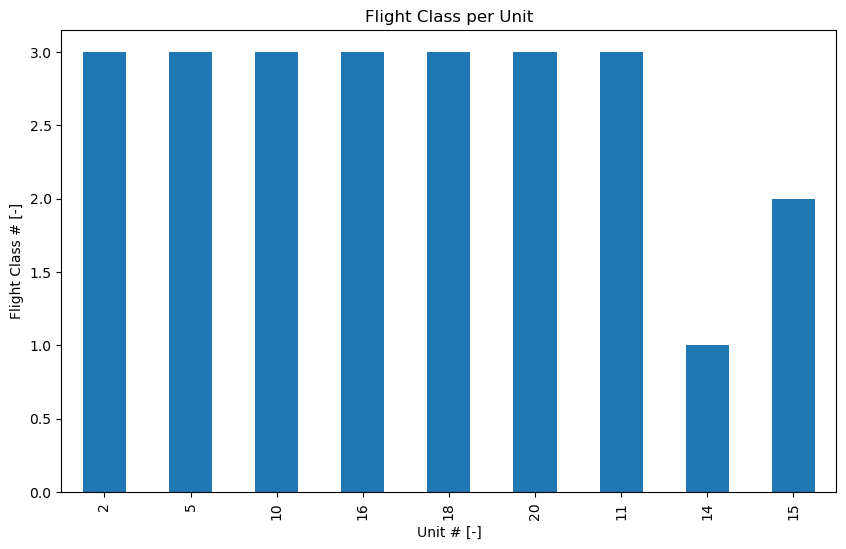

In [578]:
# Plot the flight class for each unit
df_unique_fc = df.drop_duplicates(subset=['unit', 'Fc'], keep='last')

df_unique_fc.plot(
    x='unit', y='Fc', 
    kind='bar', 
    xlabel='Unit # [-]', 
    ylabel='Flight Class # [-]',
    title='Flight Class per Unit',
    legend=False,
    figsize=(10,6)
)
plt.show()

## Feature Overview

In [579]:
LABELS = ['RUL']

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [580]:
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [581]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


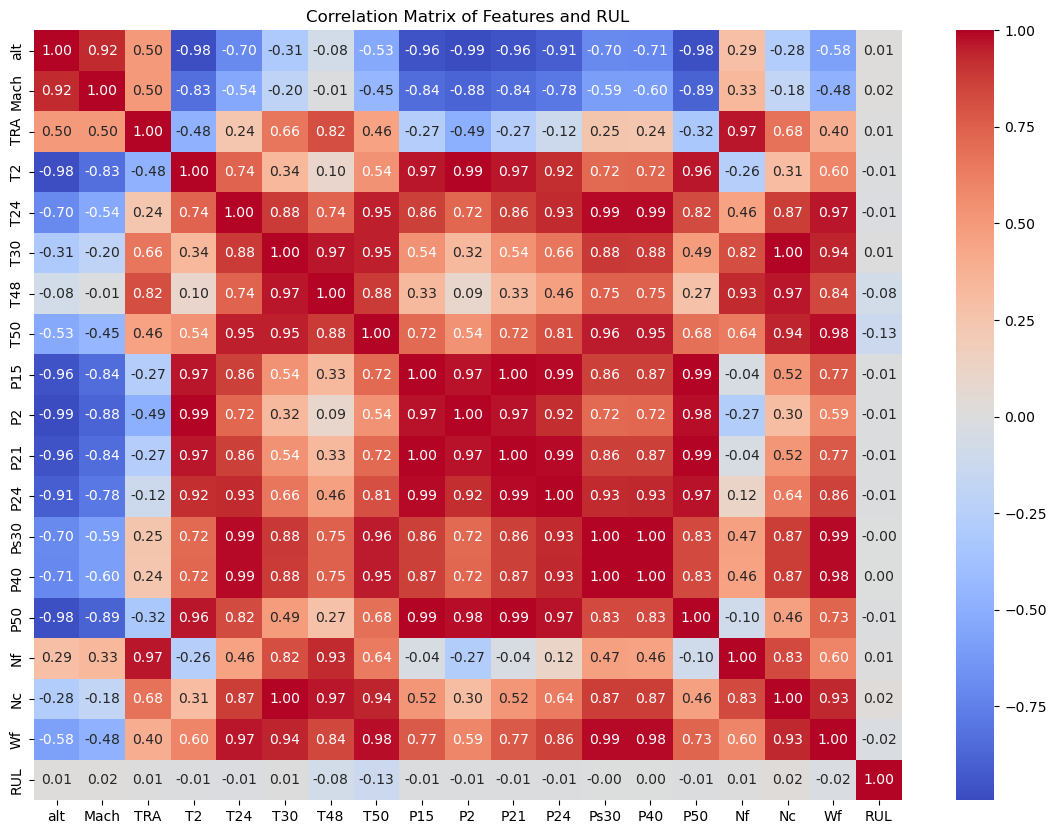

In [582]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
corr_matrix = df[W_VAR + XS_VAR + LABELS].corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features and RUL')
plt.show()

### Flight Traces
visualize a single flight trace of a given unit

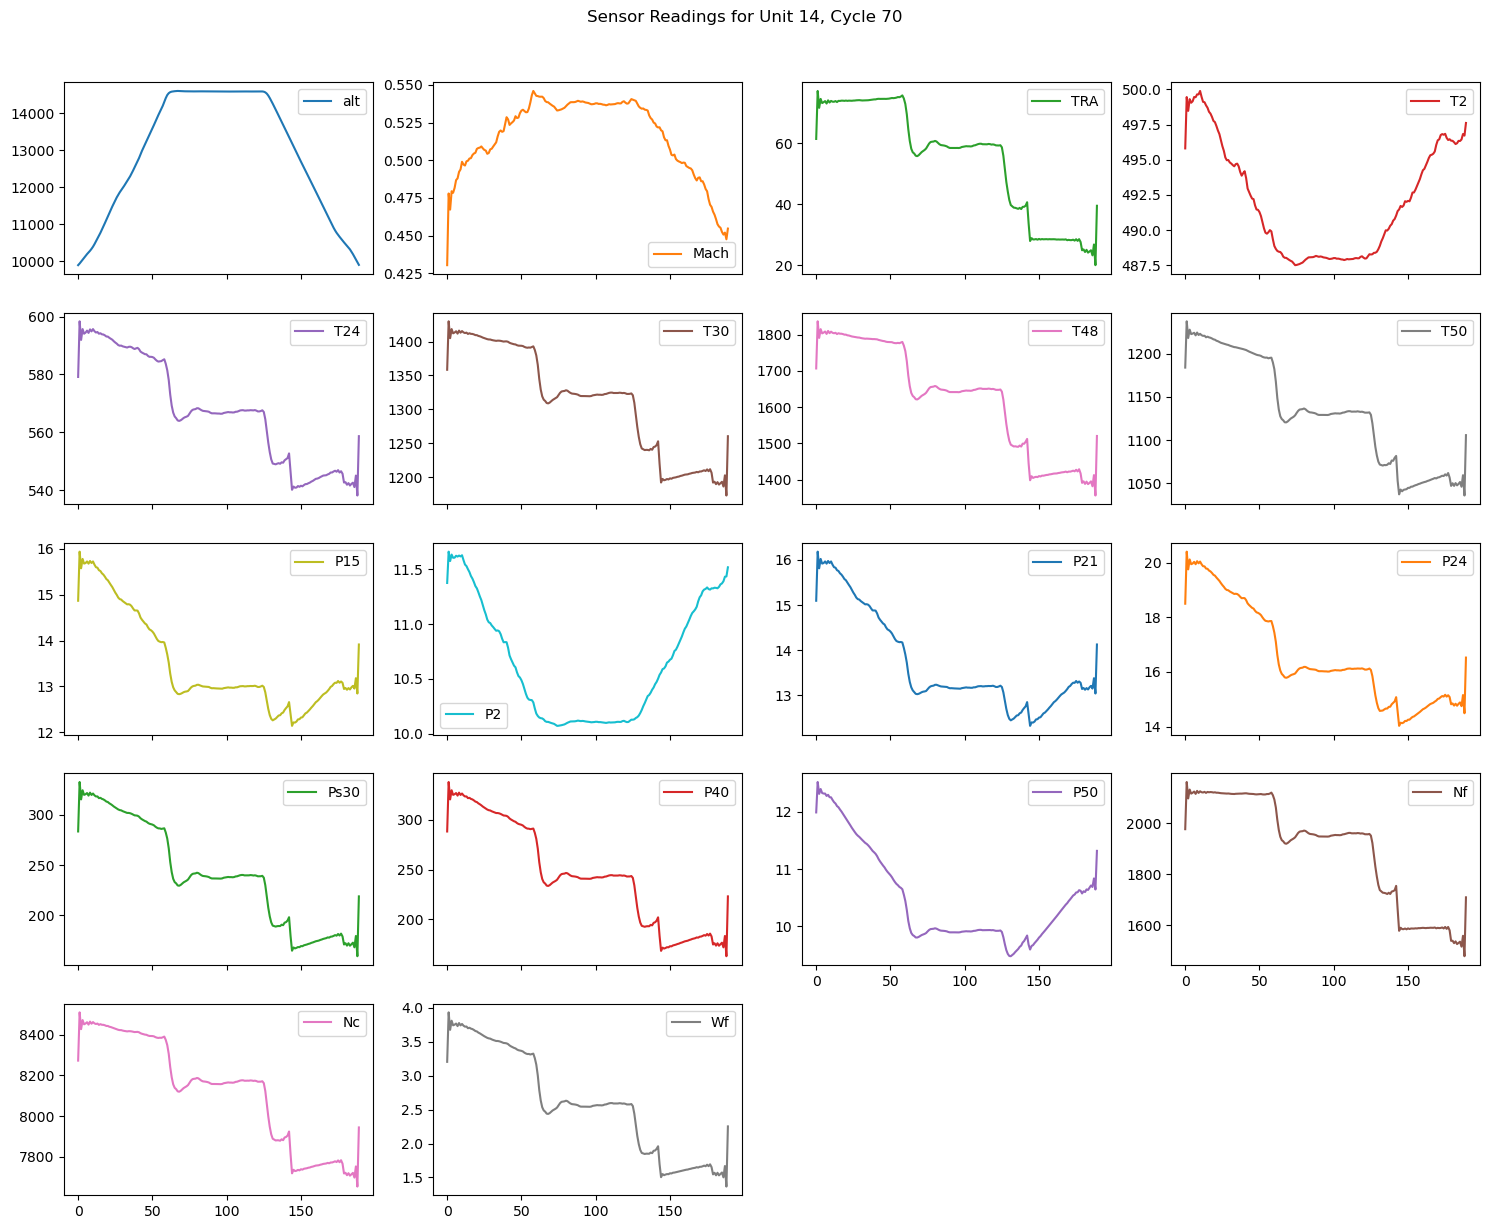

In [583]:
unit = 14
cycle = 70

# Filter data for the selected unit and cycle
df_u_sel = df[(df['unit'] == unit) & (df['cycle'] == cycle)][W_VAR + XS_VAR]
df_u_sel.reset_index(drop=True, inplace=True)

# Plot sensor readings
axes = df_u_sel.plot(figsize=(15, 12), subplots=True, layout=(5, 4))
plt.suptitle(f'Sensor Readings for Unit {unit}, Cycle {cycle}', y=1.02)
plt.tight_layout()
plt.show()


In [584]:
def plot_variables_over_cycles(units, cycles, variables, additional_variables, ylim_dict):
    # Create subplots
    num_vars = len(variables) + len(additional_variables)
    fig, axes = plt.subplots(num_vars, len(cycles), figsize=(5 * len(cycles), 3 * num_vars), sharey=False)

    for i, var in enumerate(variables + additional_variables):
        for j, cycle in enumerate(cycles):
            for unit in units:
                # Filter the dataframe for the specific unit and cycle
                df_u_sel = df[(df['unit'] == unit) & (df['cycle'] == cycle)][[var]]
                df_u_sel.reset_index(drop=True, inplace=True)

                # Plot each variable
                color = 'tab:blue' if var in variables else 'tab:orange'
                axes[i, j].plot(df_u_sel, label=f'Engine {unit}', color=color)

            # Set titles and labels
            if j == 0:
                axes[i, j].set_ylabel(var)
            if i == 0:
                axes[i, j].set_title(f'Cycle {cycle}')

            # Set y-axis limits based on the variable
            if var in ylim_dict:
                axes[i, j].set_ylim(ylim_dict[var])

            axes[i, j].legend()

    # Set common labels
    fig.text(0.5, 0.04, 'Time Steps', ha='center')
    fig.text(0.04, 0.5, 'Sensor Readings', va='center', rotation='vertical')

    plt.tight_layout()
    plt.show()

# Define variables to plot
variables = ['T24', 'T50', 'P24', 'P50']
additional_variables = ['Nf', 'Wf']
ylim_dict = {
    'T24': (460, 610),
    'T50': (800, 1300),
    'P24': (8, 22),
    'P50': (4, 14),
    'Nf': (1350, 2250),
    'Wf': (0, 6)
}

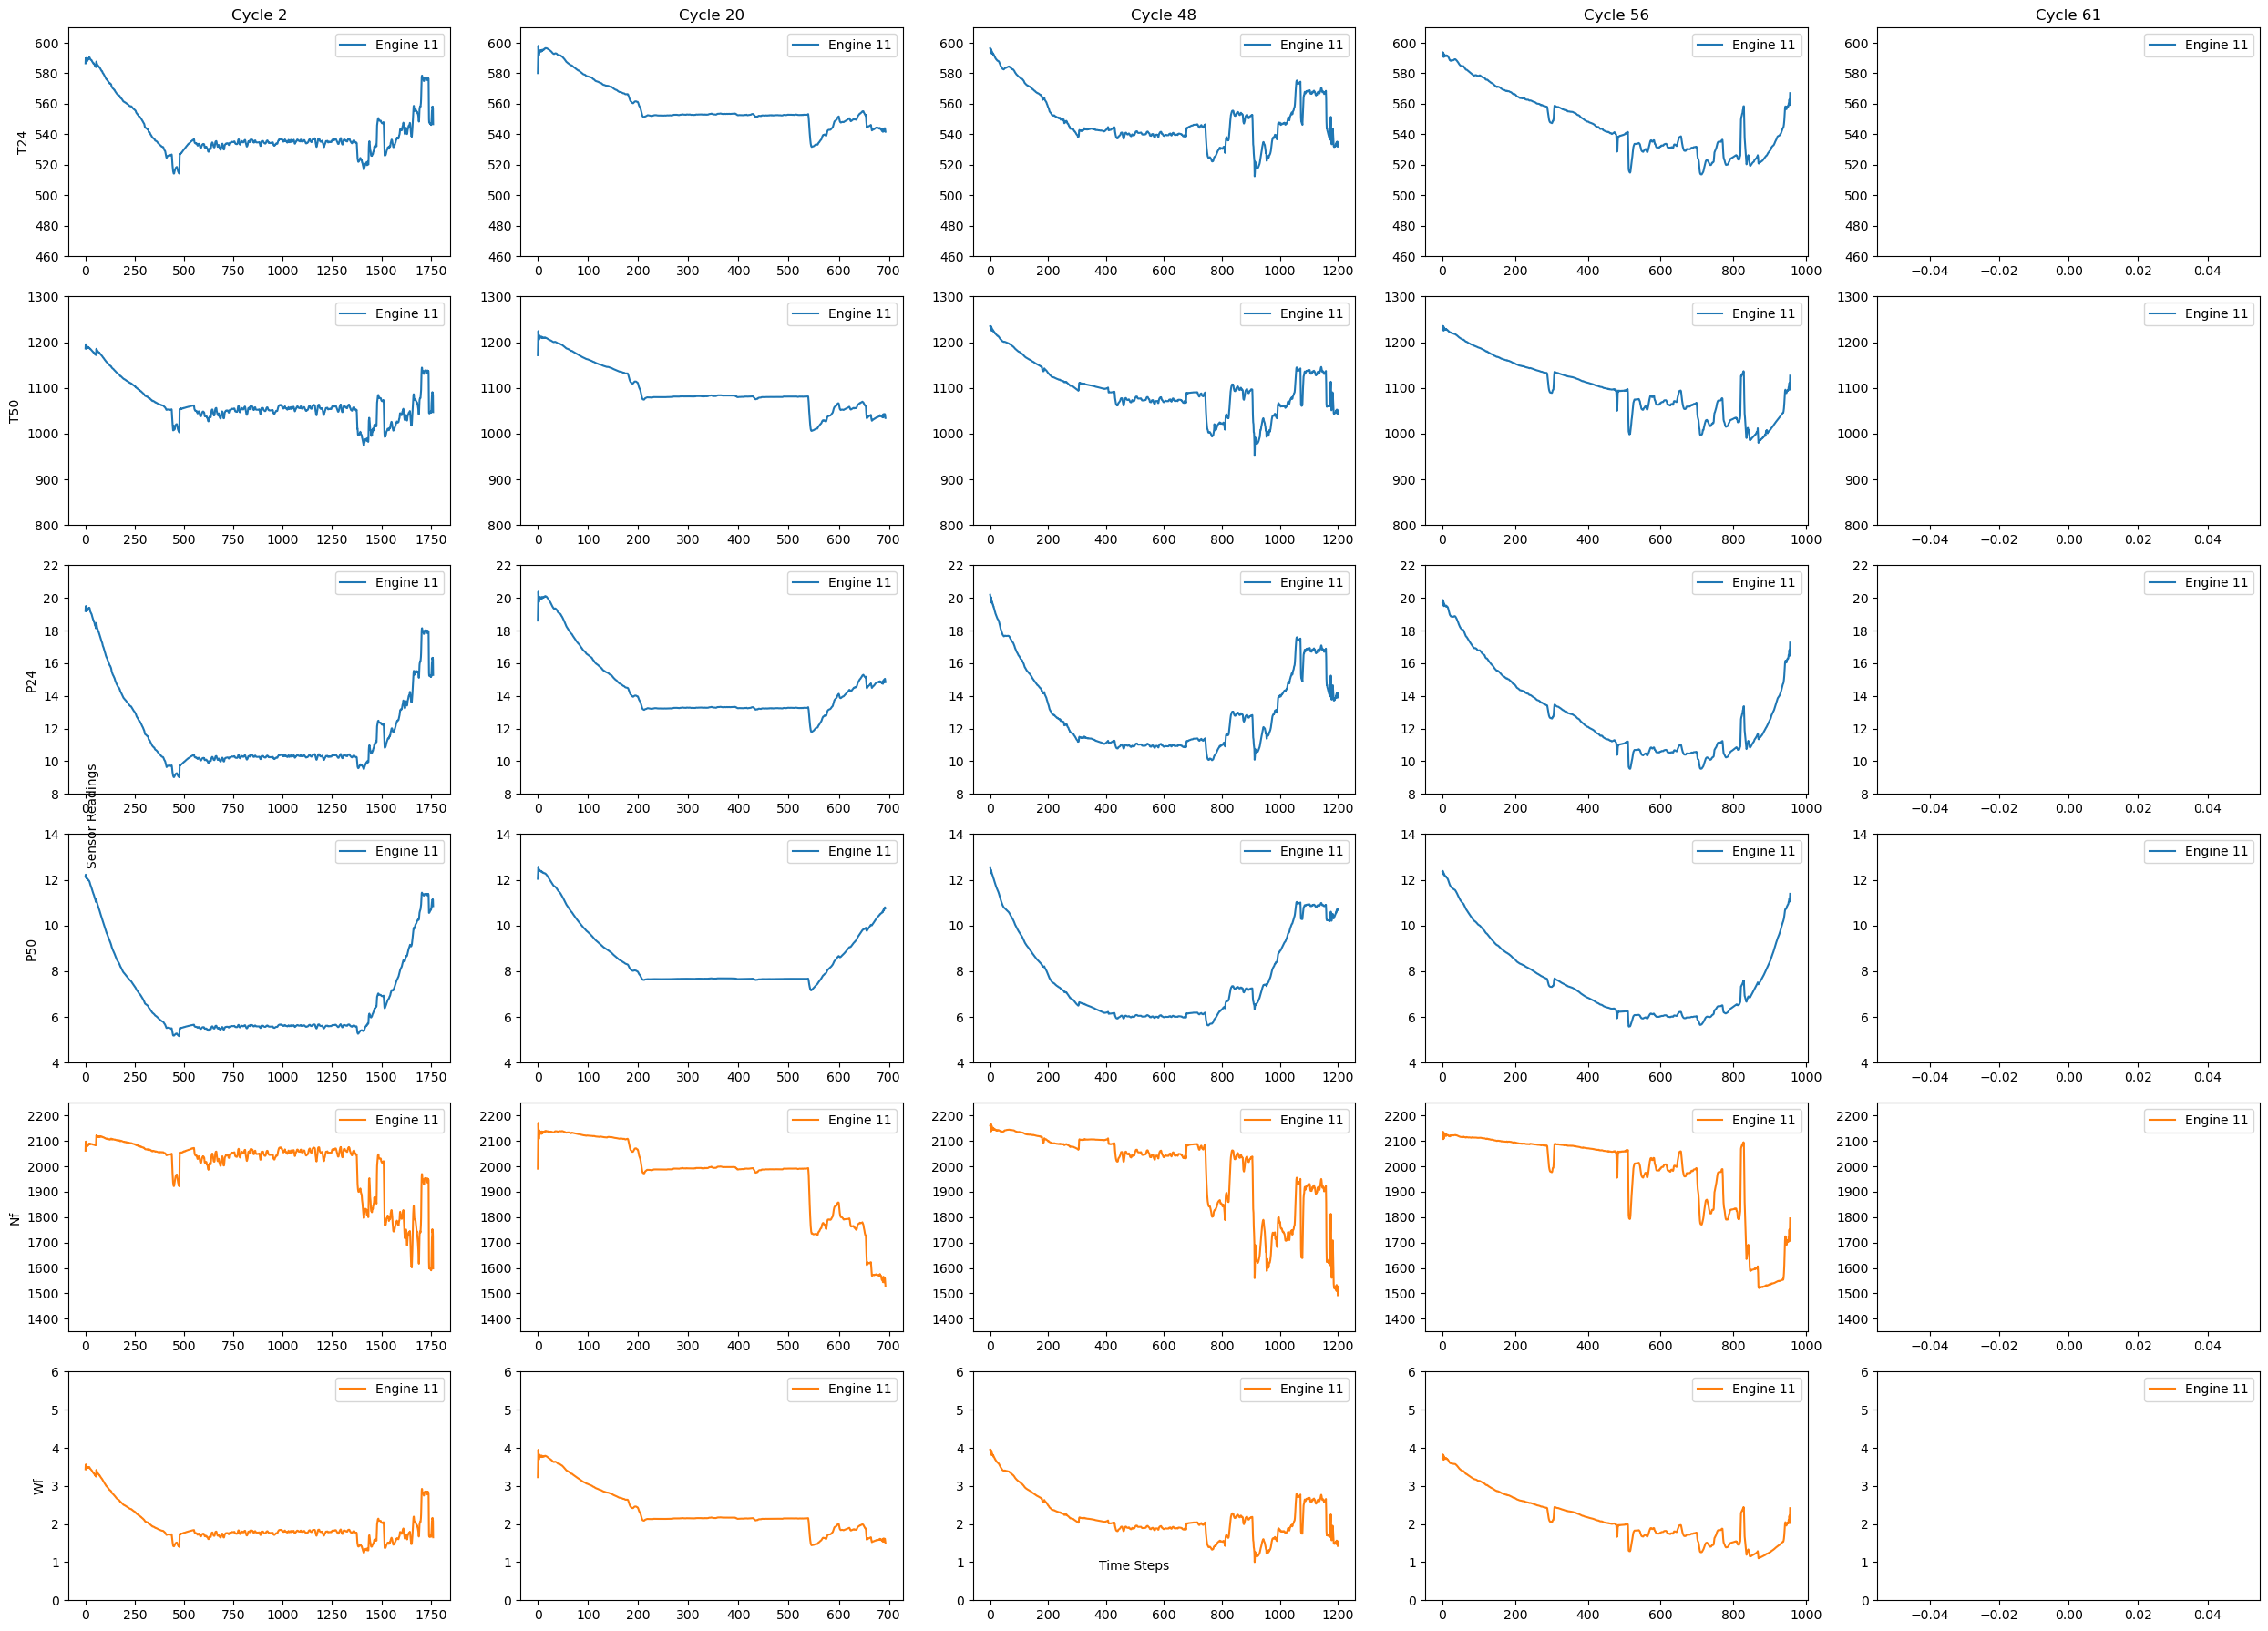

In [585]:
# Plot for Unit 11
units = [11]
cycles = [2, 20, 48, 56, 61]
plot_variables_over_cycles(units, cycles, variables, additional_variables, ylim_dict)

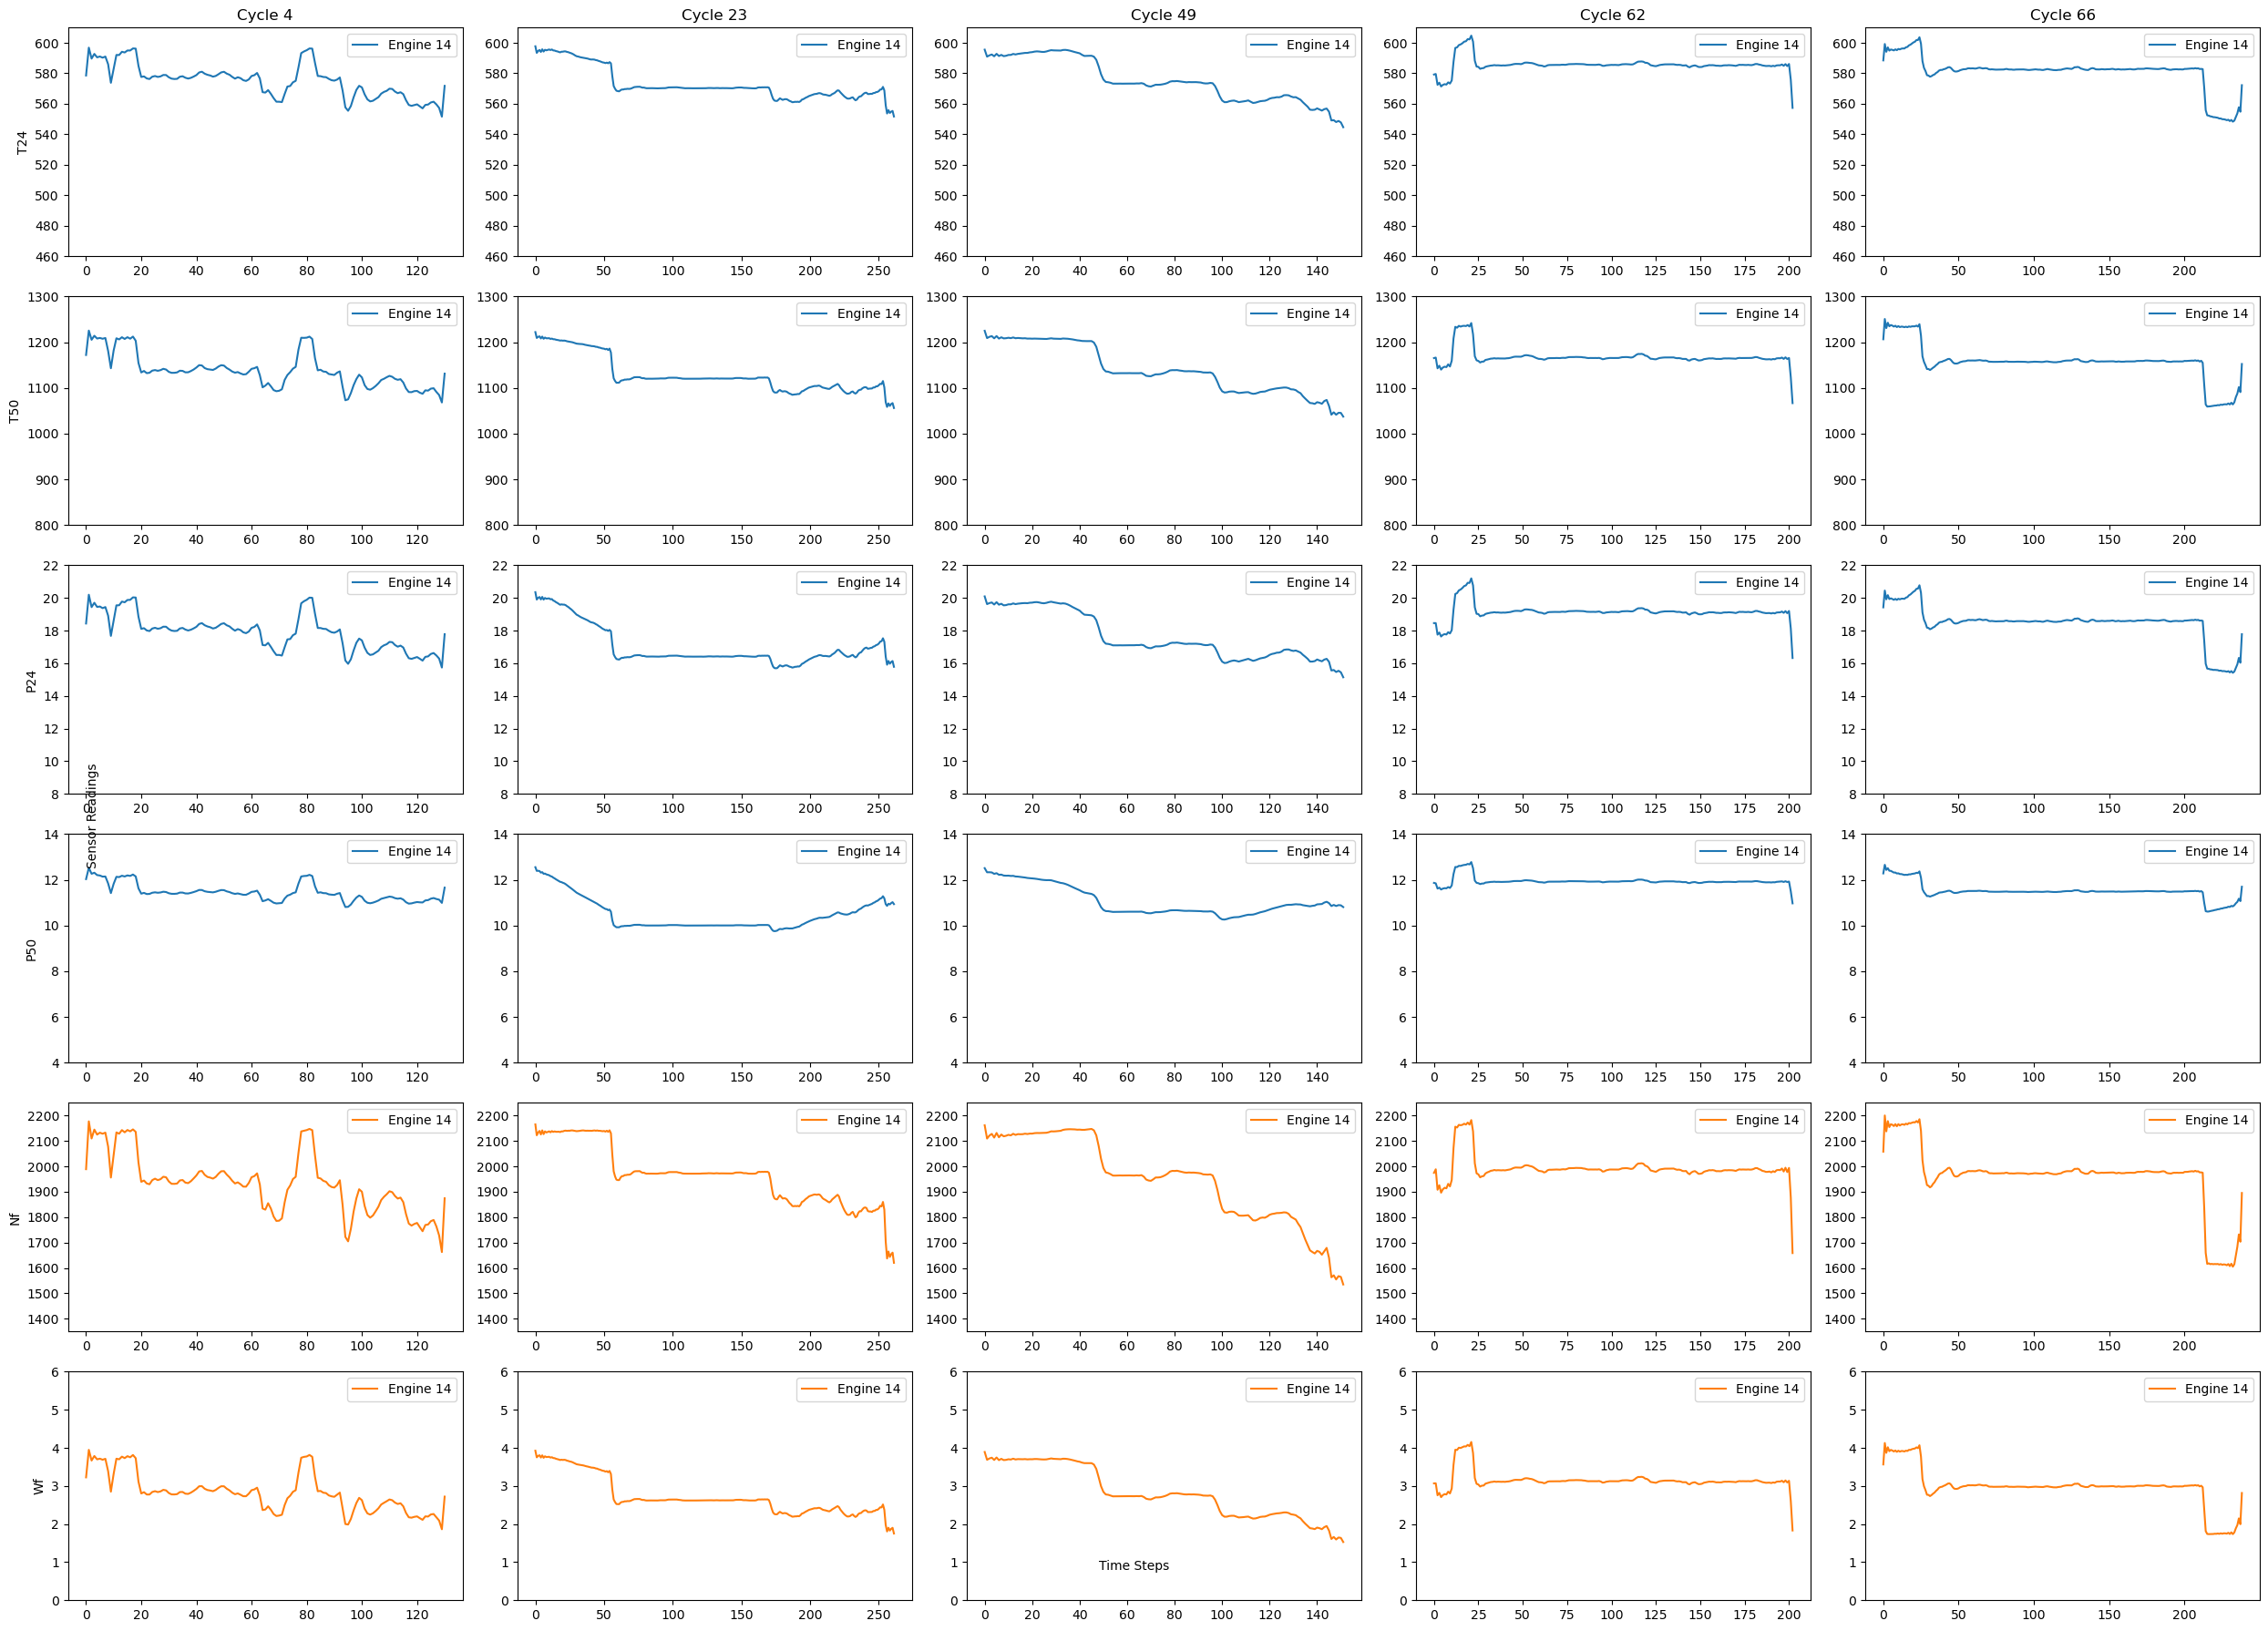

In [586]:
# Plot for Unit 14
units = [14]
cycles = [4, 23, 49, 62, 66]
plot_variables_over_cycles(units, cycles, variables, additional_variables, ylim_dict)

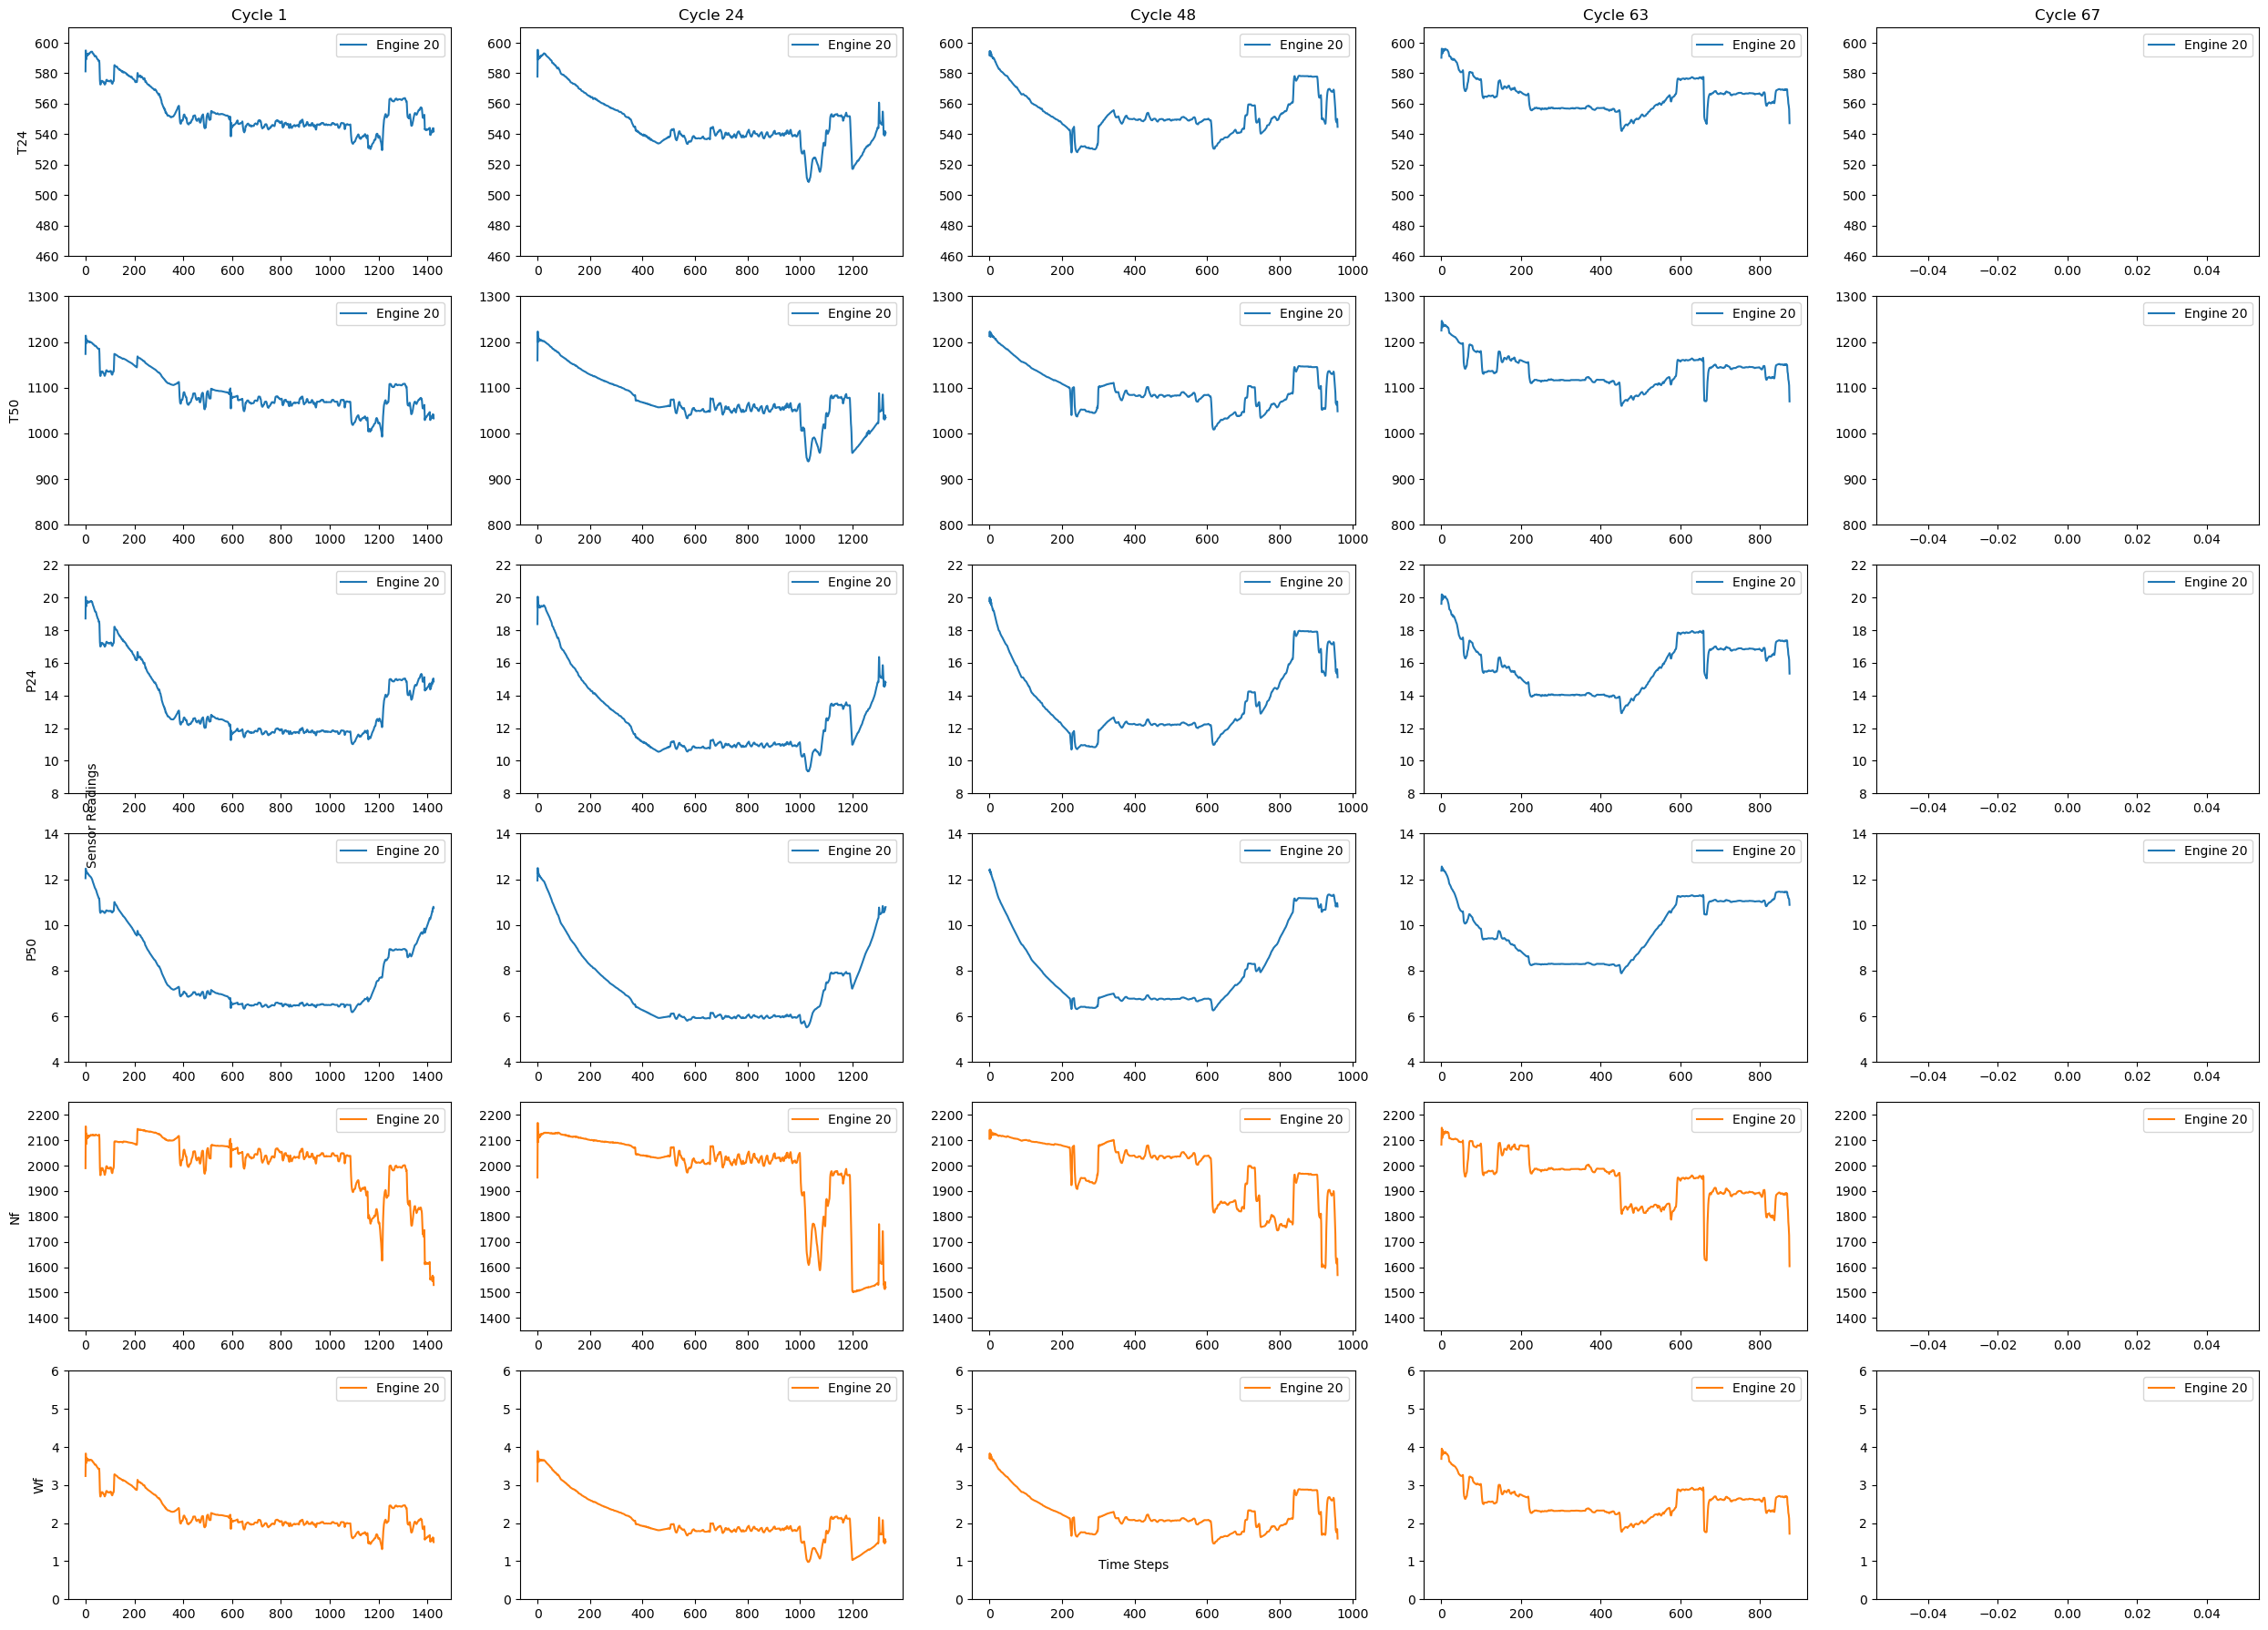

In [587]:
# Plot for Unit 20
units = [20]
cycles = [1, 24, 48, 63, 67]
plot_variables_over_cycles(units, cycles, variables, additional_variables, ylim_dict)

### Flight envelope

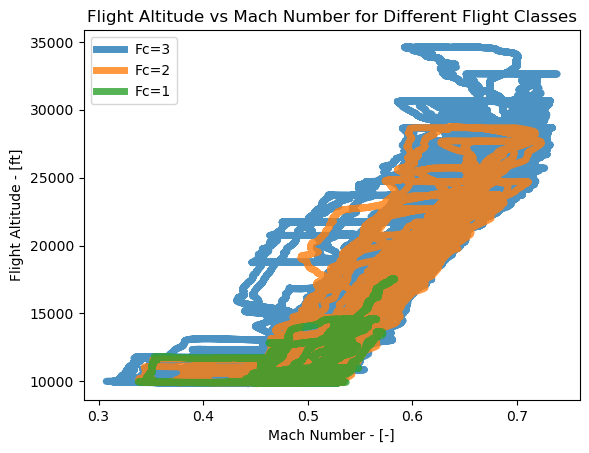

In [588]:
f, ax = plt.subplots(1, 1)
for i in [3, 2, 1]:
    df.loc[df['Fc'] == i].plot(x='Mach', y='alt', alpha=0.8, label=f'Fc={i}', ax=ax, lw=5)
plt.xlabel('Mach Number - [-]')
plt.ylabel('Flight Altitude - [ft]')
plt.title('Flight Altitude vs Mach Number for Different Flight Classes')
plt.legend()

## Histogram of Flight Conditions

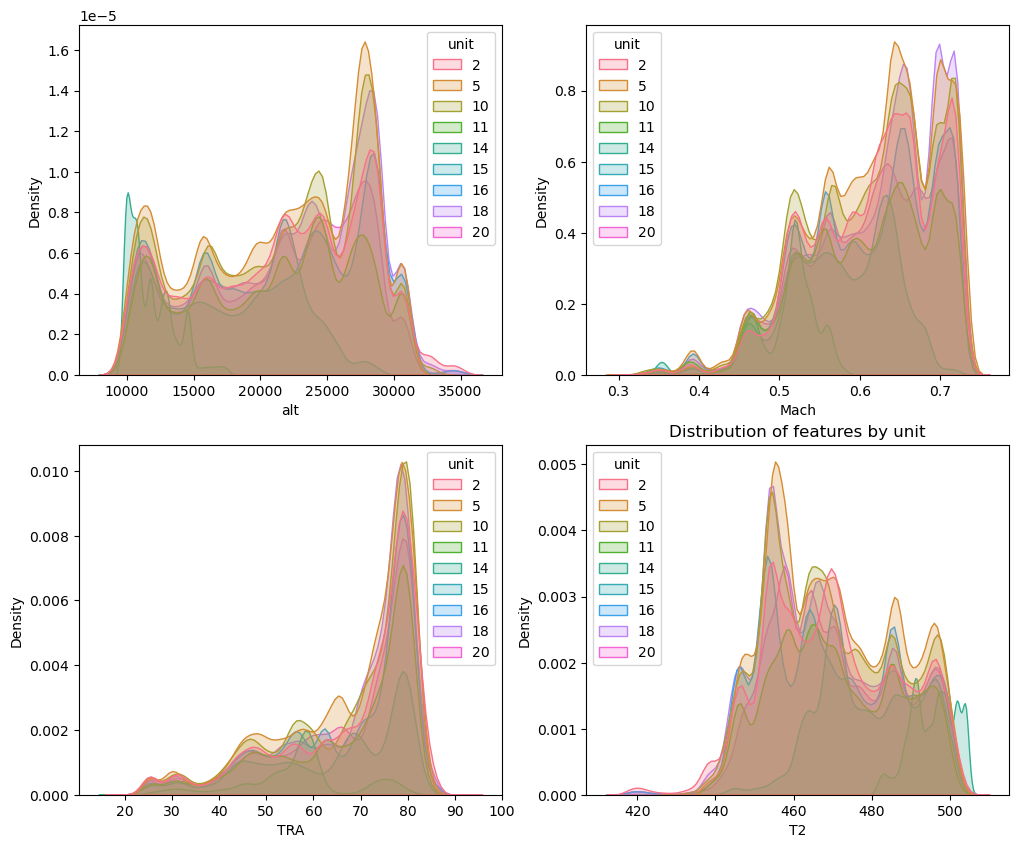

In [589]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.title(f'Distribution of features by unit')
for i, var in enumerate(W_VAR):
    sns.kdeplot(data=df[W_VAR+['unit']], x=var, hue='unit', shade=True, gridsize=100, ax=axes[i//2][i%2], palette=sns.color_palette("husl", 9))
plt.show()

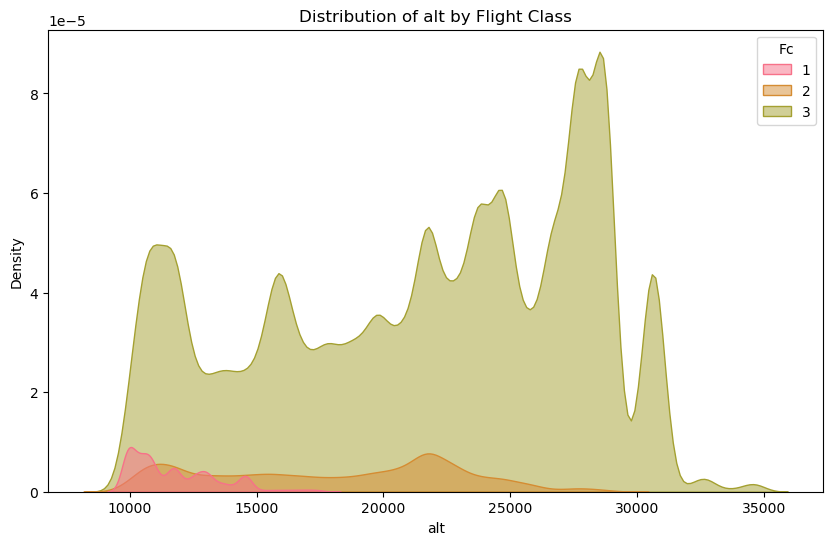

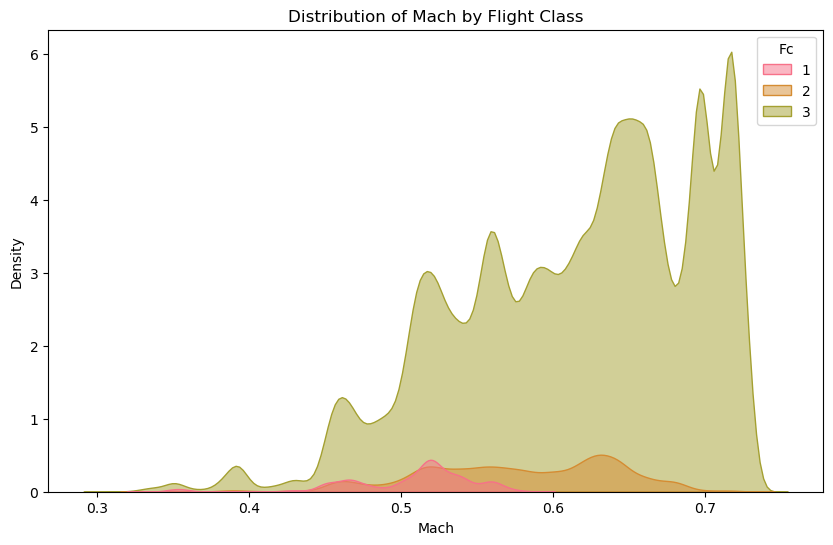

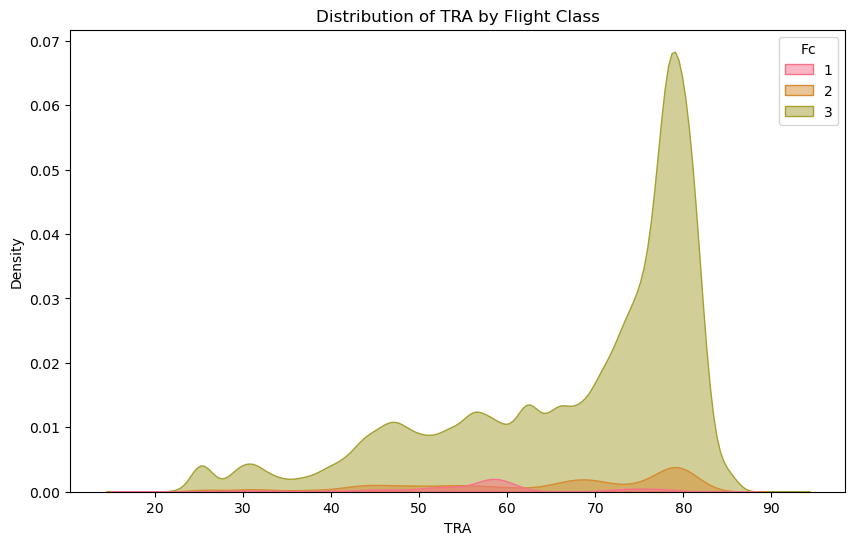

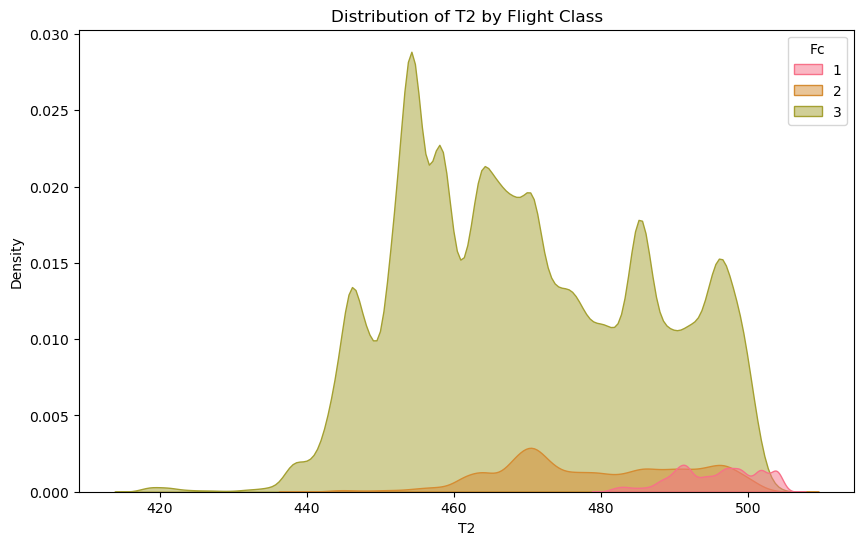

In [590]:
# KDE plots of scenario-descriptor variables by flight class
for var in W_VAR:
    plt.figure(figsize=(10,6))
    sns.kdeplot(data=df, x=var, hue='Fc', shade=True, palette=sns.color_palette("husl", 9), alpha=0.5)
    plt.title(f'Distribution of {var} by Flight Class')
    plt.show()


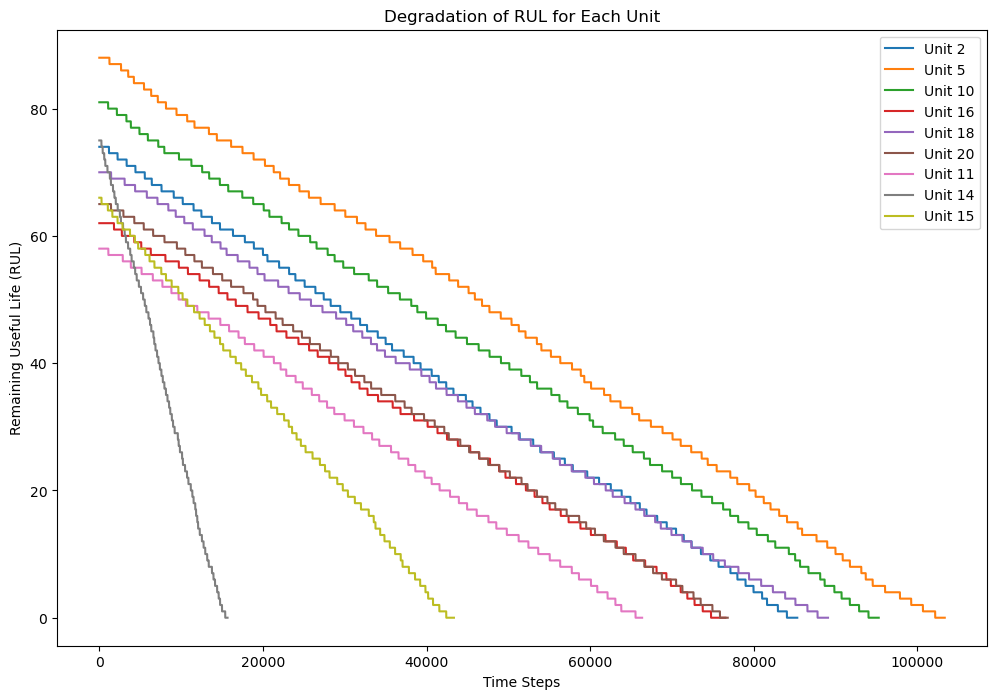

In [591]:
# Plot degradation of RUL for each unit
units = [2, 5, 10, 16, 18, 20, 11, 14, 15]
plt.figure(figsize=(12, 8))
for i in units:
    plt.plot(df[df['unit'] == i]['RUL'].reset_index(drop=True), label=f'Unit {i}')
plt.xlabel('Time Steps')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Degradation of RUL for Each Unit')
plt.legend()
plt.show()

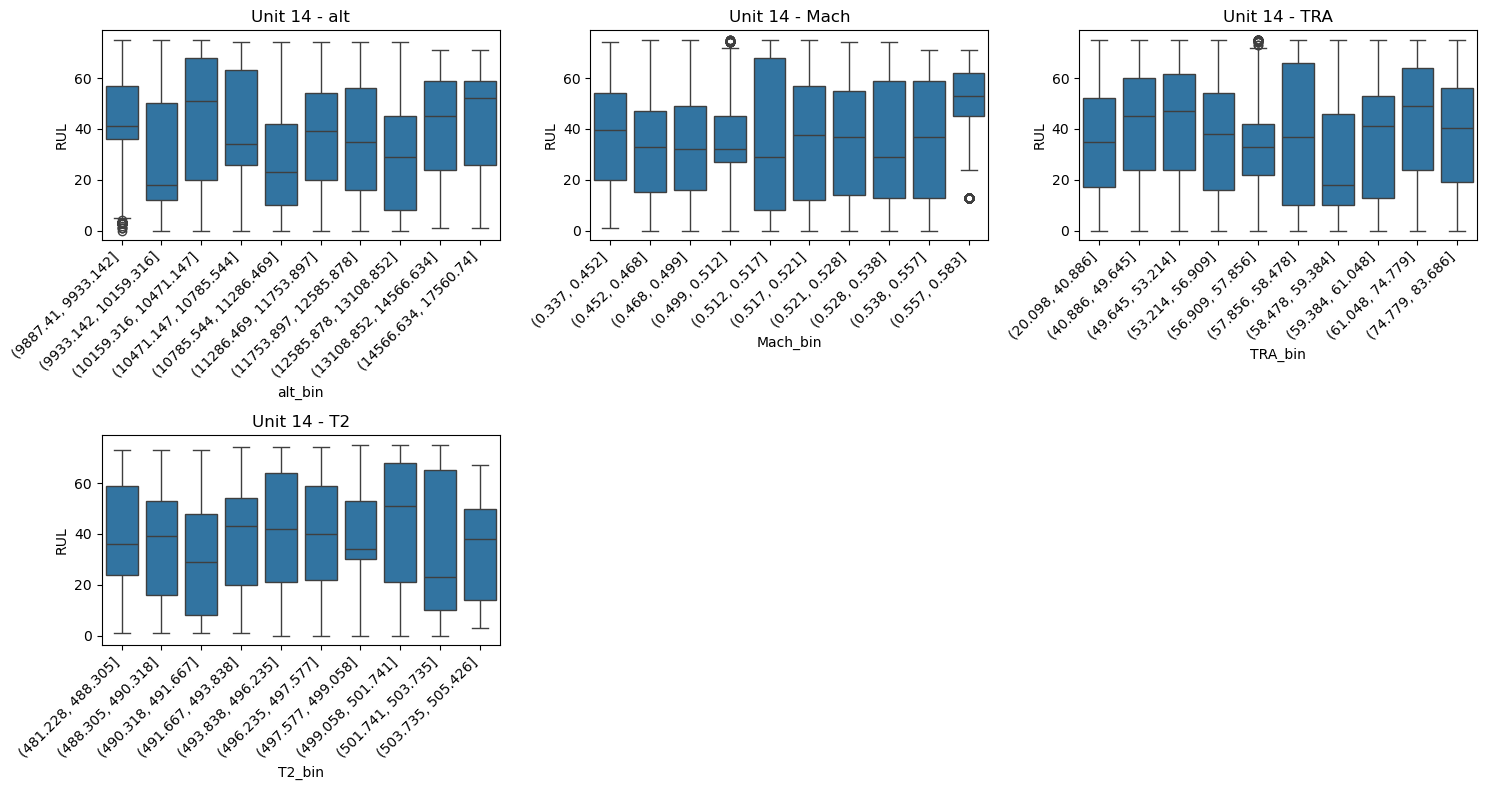

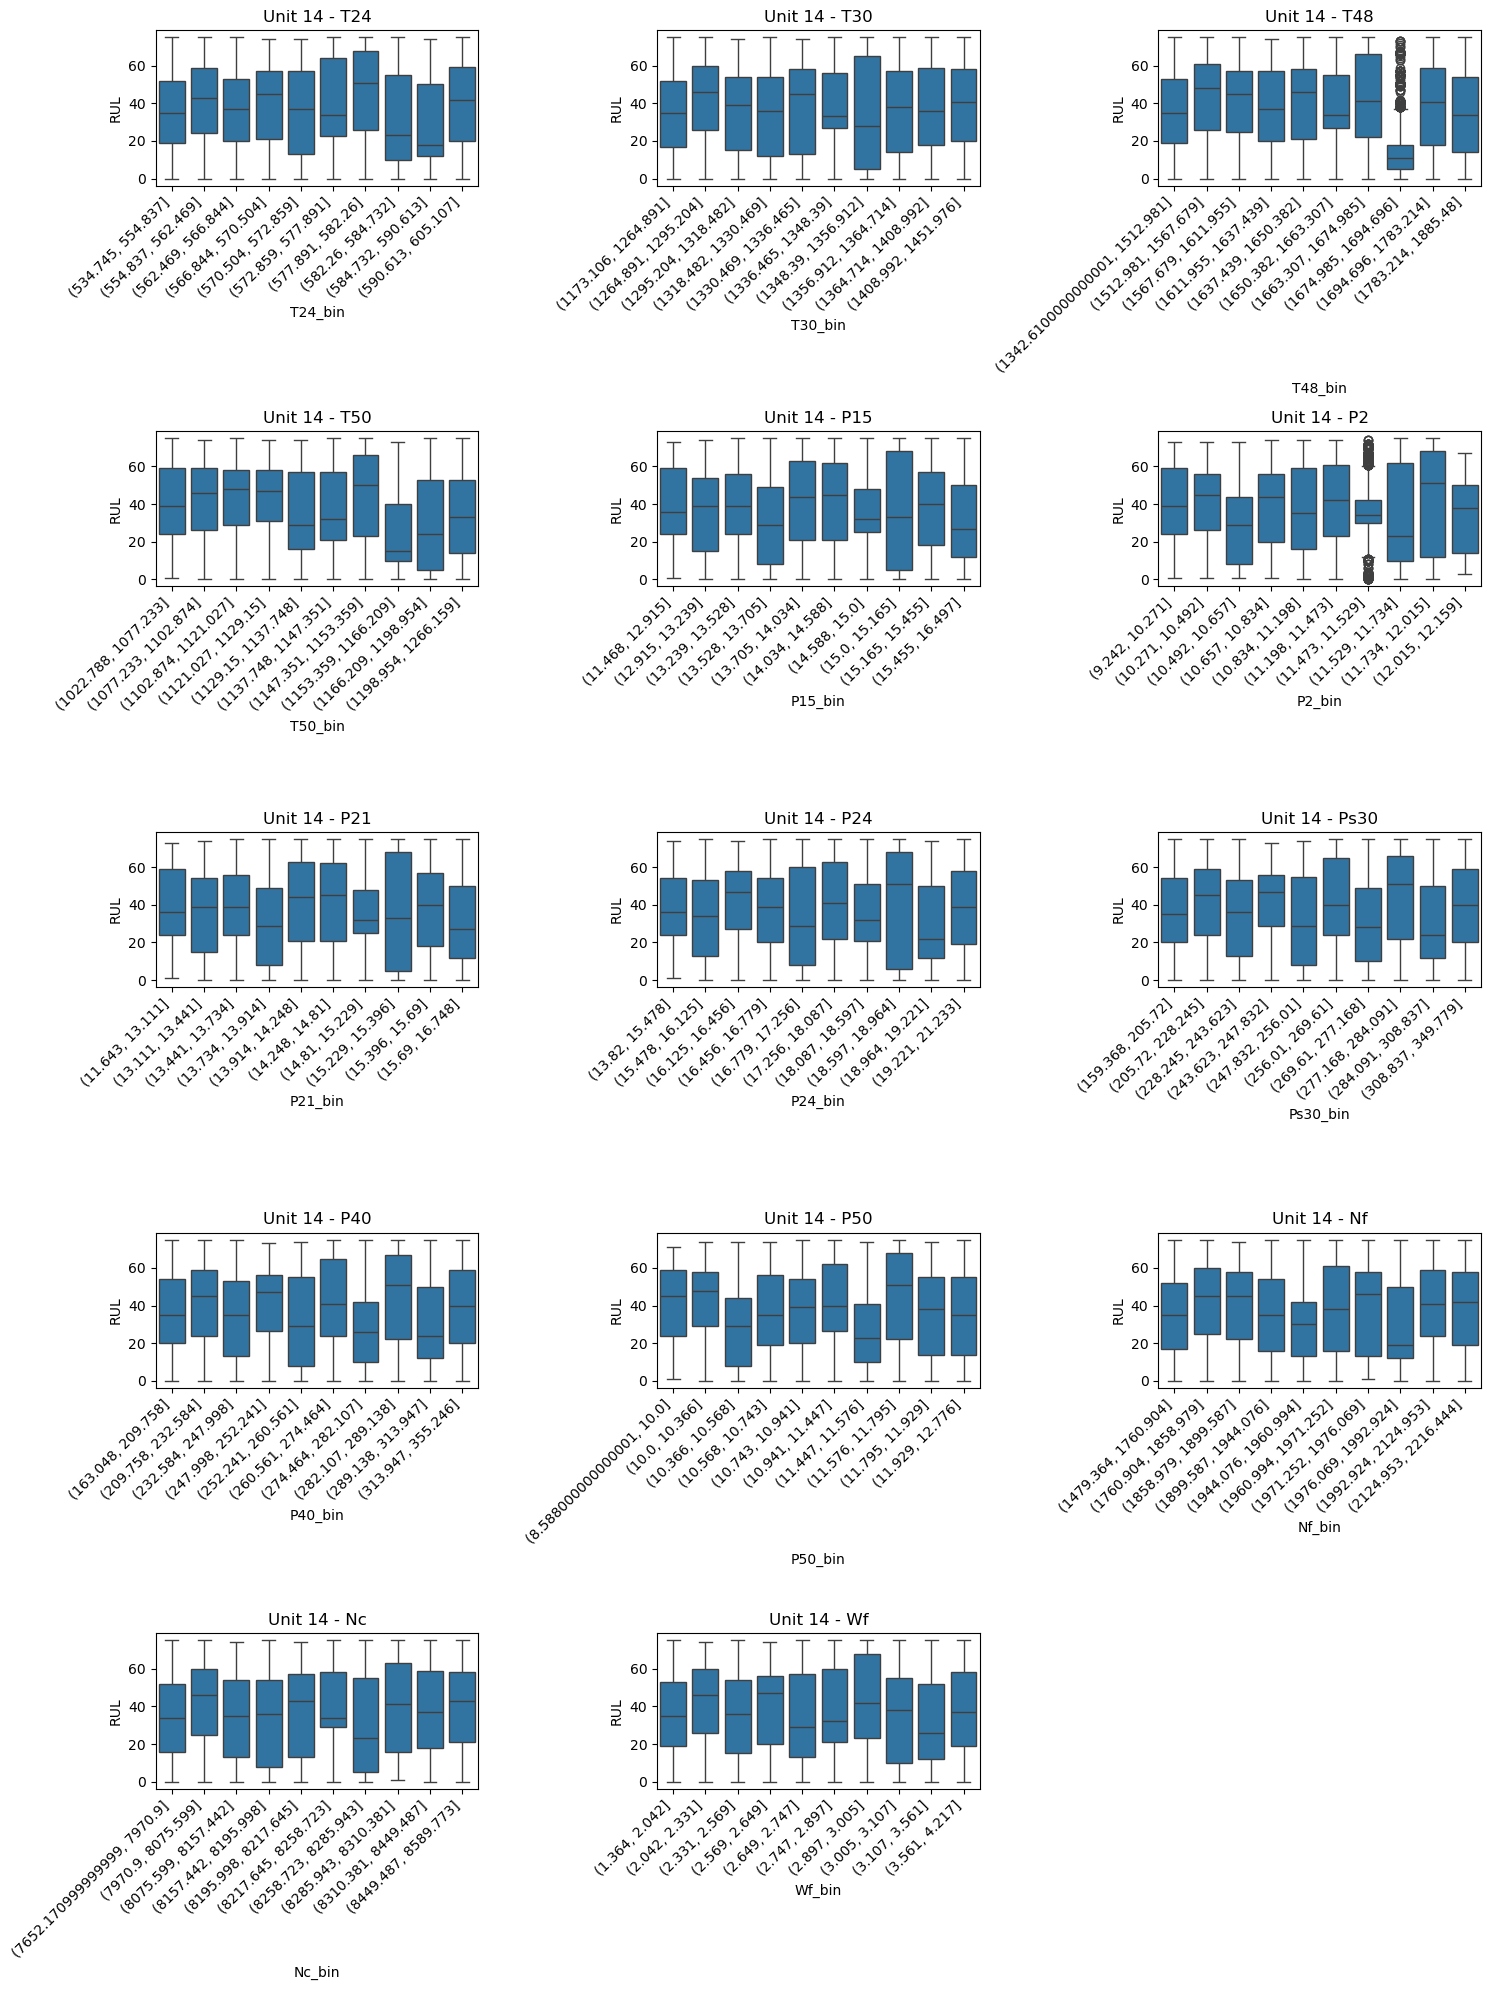

In [592]:
# Plot boxplots of RUL vs variables
def plot_rul_vs_variables(unit, variables):
    processData = df[df['unit'] == unit][variables + LABELS].copy()
    num_vars = len(variables)
    num_cols = 3
    num_rows = (num_vars + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axes = axes.flatten()

    for i, var in enumerate(variables):
        # Bin the variable into quantiles
        processData[var + '_bin'] = pd.qcut(processData[var], q=10, duplicates='drop')
        sns.boxplot(data=processData, x=var + '_bin', y='RUL', ax=axes[i])
        axes[i].set_title(f'Unit {unit} - {var}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot RUL vs W_VAR for Unit 14
plot_rul_vs_variables(unit=14, variables=W_VAR)

# Plot RUL vs XS_VAR for Unit 14
plot_rul_vs_variables(unit=14, variables=XS_VAR)


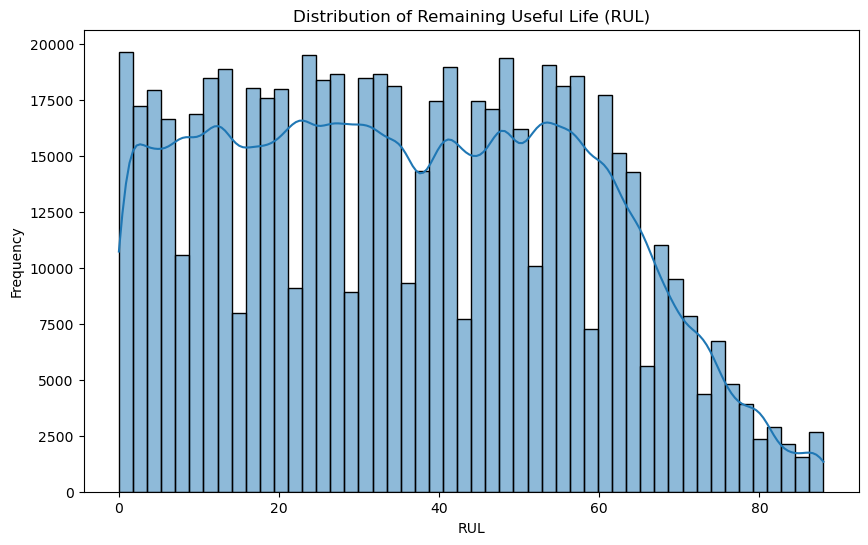

In [593]:
# Histogram of RUL for all units
plt.figure(figsize=(10,6))
sns.histplot(df['RUL'], bins=50, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.show()

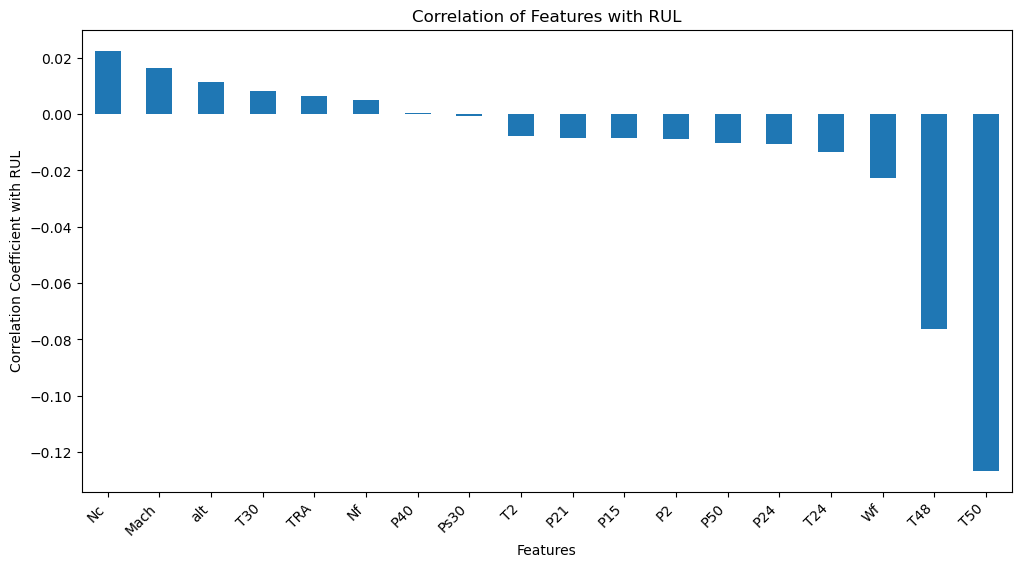

In [594]:
# Calculate correlation coefficients between features and RUL
corr_with_rul = df[XS_VAR + W_VAR + LABELS].corr()['RUL'].drop('RUL').sort_values(ascending=False)

# Plot correlations
plt.figure(figsize=(12,6))
corr_with_rul.plot(kind='bar')
plt.title('Correlation of Features with RUL')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient with RUL')
plt.xticks(rotation=45, ha='right')
plt.show()

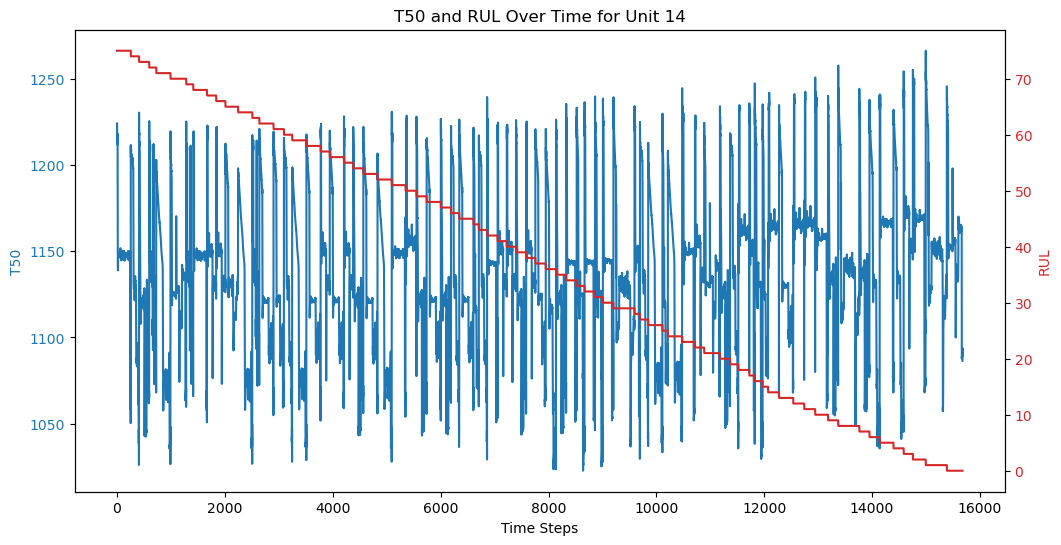

In [595]:
# Time series plot of a sensor and RUL for a unit
unit = 14
sensor = 'T50'

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Time Steps')
ax1.set_ylabel(sensor, color=color)
ax1.plot(df[df['unit'] == unit][sensor].reset_index(drop=True), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('RUL', color=color)
ax2.plot(df[df['unit'] == unit]['RUL'].reset_index(drop=True), color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'{sensor} and RUL Over Time for Unit {unit}')
plt.show()

# Developing your first prognostics model 💻
Step by step, you will learn how to build your first prognostics model from scratch!

## Define Sequence Dataset 


In [596]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, window=50, stride=1, horizon=1, device='cpu'):
        """Sliding window dataset with RUL label

        Args:
            dataframe (pd.DataFrame): dataframe containing scenario descriptors and sensor reading
            window (int, optional): sequence window length. Defaults to 50.
            stride (int, optional): data stride length. Defaults to 1.
            horizon (int, optional): prediction forcasting length. Defaults to 1.
        """
        self.window = window
        self.stride = stride
        self.horizon = horizon
        
        self.X = np.array(dataframe[XS_VAR+W_VAR].values).astype(np.float32)
        self.y = np.array(dataframe['RUL'].values).astype(np.float32)
        self.units = np.array(dataframe['unit'].values).astype(np.int32)

        if 'ds' in dataframe.columns:
            unqiue_cycles = dataframe[['ds', 'unit', 'cycle']].value_counts(sort=False)
        else:
            unqiue_cycles = dataframe[['unit', 'cycle']].value_counts(sort=False)
        self.indices = torch.from_numpy(self._get_indices(unqiue_cycles)).to(device)

    # get corresponding indices of the dataframe for sliding windows at pos i
    def _get_indices(self, unqiue_cycles):
        cycles = unqiue_cycles.to_numpy()
        idx_list = []
        for i, c_count in enumerate(cycles):
            c_start = sum(cycles[:i])
            c_end = c_start + (c_count - self.window - self.horizon)
            if c_end + self.horizon < len(self.X): # handling y not in the last seq case
                idx_list += [_ for _ in np.arange(c_start, c_end + 1, self.stride)]
        return np.asarray([(idx, idx+self.window) for idx in idx_list])
    
    # find length of data with sliding window
    def __len__(self):
        return len(self.indices)
    
    # get corresponding sliding window
    def __getitem__(self, i):
        i_start, i_stop = self.indices[i]
        x = self.X[i_start:i_stop, :]
        y = self.y[i_start]
        unit = self.units[i_start]  # Get the unit label
        x = x.permute(1, 0)
        y = torch.tensor(y)
        unit = torch.tensor(unit)
        return x, y, unit

In [597]:
def create_datasets(df, window_size, train_units, test_units, device='cpu'):
    df_train = df[df['unit'].isin(train_units)]
    train_dataset = SlidingWindowDataset(df_train, window=window_size)

    df_test = df[df['unit'].isin(test_units)]    
    test_dataset = SlidingWindowDataset(df_test, window=window_size)

    # normalizing features
    scaler = MinMaxScaler()
    train_dataset.X = scaler.fit_transform(train_dataset.X)
    test_dataset.X = scaler.transform(test_dataset.X)

    # convert numpy array to tensors
    datasets = [train_dataset, test_dataset]
    for d in datasets:
        d.X = torch.from_numpy(d.X).to(device)
        d.y = torch.from_numpy(d.y).to(device)
    
    return datasets

def create_data_loaders(datasets, batch_size=256, val_split=0.2):
    # fixed seed for data splits for reproducibility
    random.seed(0)
    np.random.seed(0)
    
    d_train, d_test = datasets
    dataset_size = len(d_train)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(d_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(d_train, batch_size=batch_size, sampler=valid_sampler)
    test_loader = DataLoader(d_test, batch_size=batch_size, shuffle=False)      

    d_info = f"train_size: {len(train_indices)}\t"
    d_info += f"validation_size: {len(val_indices)}\t"
    d_info += f"test_size: {len(d_test)}"
    print(d_info)
    return train_loader, val_loader, test_loader

## Define Trainer Class

In [598]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        n_epochs=20,
        criterion=nn.MSELoss(),
        model_name='best_model',
        seed=42,
        device='cpu'
    ):
        self.seed = seed
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.n_epochs = n_epochs
        self.criterion = criterion
        
        # adding time_stamp to model name to make sure the save models don't overwrite each other, 
        # you can customize your own model name with hyperparameters so that you can reload the model more easily
        time_stamp = time.strftime("%m%d%H%M%S")
        self.model_path = f'models/{model_name}_{time_stamp}.pt'

        self.losses = {split: [] for split in ['train', 'eval', 'test']}
        
    def compute_loss(self, x, y, model=None):
        y = y.view(-1)
        y_pred = self.model(x)
        y_pred = y_pred.view(-1)
        loss = self.criterion(y, y_pred)
        return loss, y_pred, y
    
    def train_epoch(self, loader):
        self.model.train()
        # batch losses
        b_losses = []
        for x, y, _ in loader:
            # Setting the optimizer gradient to Zero
            self.optimizer.zero_grad()
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))
            
            loss, pred, target = self.compute_loss(x, y)
            
            # Backpropagate the training loss
            loss.backward()
            self.optimizer.step()
            b_losses.append(loss.detach().numpy())
        
        # aggregated losses across batches
        agg_loss = np.sqrt((np.asarray(b_losses) ** 2).mean())
        self.losses['train'].append(agg_loss)
        return agg_loss

    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_epoch(self, loader, split='eval'):
        self.model.eval()
        # batch losses
        b_losses = []
        for x, y, _ in loader:
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))
            
            loss, pred, target = self.compute_loss(x, y)
            
            b_losses.append(loss.detach().numpy())
        
        # aggregated losses across batches
        agg_loss = np.sqrt((np.asarray(b_losses) ** 2).mean())
        self.losses[split].append(agg_loss)
        return agg_loss
        
    def fit(self, loaders):
        print(f"Training model for {self.n_epochs} epochs...")
        train_loader, eval_loader, test_loader = loaders
        train_start = time.time()
        
        start_epoch = 0
        best_eval_loss = np.inf
            
        for epoch in range(start_epoch, self.n_epochs):
            epoch_start = time.time()
            
            train_loss = self.train_epoch(train_loader)
            eval_loss = self.eval_epoch(eval_loader, split='eval')
            test_loss = self.eval_epoch(test_loader, split='test')

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                self.save(self.model, self.model_path)

            s = (
                f"[Epoch {epoch + 1}] "
                f"train_loss = {train_loss:.5f}, "
                f"eval_loss = {eval_loss:.5f}, "
                f"test_loss = {test_loss:.5f}"
            )

            epoch_time = time.time() - epoch_start
            s += f" [{epoch_time:.1f}s]"
            print(s)
    
        train_time = int(time.time() - train_start)
                
        print(f'Task done in {train_time}s')
    
    @ staticmethod
    def evaluate_model_performance(y_pred, y_true):
        """
        ## Task: Define Model Performance on RMSE and NASA score
        The performance of your implemented model should be evaluated using two common metrics applied in N-CMAPSS prognostics analysis:
        RMSE and NASA-score (in 1E5) as introduced in ["Fusing Physics-based and Deep Learning Models for Prognostics"](https://arxiv.org/abs/2003.00732)
        """
        # TODO: add implementation
        # for NASA score: alpha = 1/13 if RUL is underestimated, and 1/10 otherwise
        delta = y_pred - y_true
        alpha = np.where(delta < 0, 1/13, 1/10) 

        NASA_score = np.exp(alpha * np.abs(delta))
        NASA_score = np.sum(NASA_score) / 1e5  

        rmse = np.sqrt(np.mean(delta ** 2))
        return NASA_score, rmse
    
    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_rul_prediction(self, test_loader):
        print(f"Evaluating test RUL...")
        
        ## MASK OUT EVAL and add explanation
        best_model = self.load(self.model) 
        best_model.eval()
        
        preds = []
        trues = []
        units = []  # Collect unit numbers

        
        for x, y, unit in tqdm(test_loader):
            x = x.to(self.device)
            y = y.to(self.device)

            _, y_pred, y_target = self.compute_loss(x, y)
            preds.append(y_pred.detach().cpu().numpy())
            trues.append(y_target.detach().cpu().numpy())
            units.append(unit.numpy())
        
        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        units = np.concatenate(units, axis=0)

        
        df = pd.DataFrame({         
            'pred': preds,
            'true': trues,
            'unit': units,
            'err': np.sqrt((preds - trues)**2)
        })
        
        score, rmse = self.evaluate_model_performance(preds, trues)
        df_out = pd.DataFrame({
            'score': [score],
            'rmse': [rmse],
            'seed': [self.seed],
        })
        return df, df_out

    def save(self, model, model_path=None):
        os.makedirs(f'{folder}/models', exist_ok=True)
        if model_path is None:
            model_path = self.model_path 
        torch.save(model.state_dict(), model_path)
        
    def load(self, model, model_path=None):
        """
        loads the prediction model's parameters
        """
        if model_path is None:
            model_path = self.model_path
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model {model.__class__.__name__} saved in {model_path} loaded to {self.device}")
        return model

    def plot_losses(self):
        """
        :param losses: dict with losses
        """
        linestyles = {
            'train': 'solid', 
            'eval': 'dashed', 
            'test': 'dotted', 
        }
        for split, loss in self.losses.items():
            ls = linestyles[split]
            plt.plot(range(1, 1+len(loss)), loss, label=f'{split} loss', linestyle=ls)
            plt.yscale('log')
                
        plt.title("Training/Validation Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


# Task: Implement a 1D Convolutional Neural Network (1DCNN) Model
Conventional CNN's developed for image tasks learn to extract features from the 2D input data. They are autonomous (require no domain expertise or prior info about the image) and thus can be applied to any image regardless of its dimensions. This is due to the fact that these CNN's go through an image by downsampling the image which we call straddling or windowing.  

Similarly 1D CNN learns to extract features from a time series data, by windowing over the data, considering a set of data observations each time. The benefit of using the CNN for sequence classification is that it can learn from the raw time series data, and in turn do not require domain expertise to engineer relevant features.

The CNN architecture outlined in the paper consists of five layers. The initial three layers are convolutional layers, each employing filters of size 10. The first two convolutional layers consist of ten channels each, while the third convolutional layer comprises a single channel. Zero padding is utilized to maintain the dimensions of the feature map throughout the network. Following the convolutional layers, the 2D feature map is flattened, leading into a 50-unit fully connected layer, and subsequently, a linear output neuron. The activation function used across the network is ReLU. The network encompasses 24,000 trainable parameters.

As an advanced extension of this task, you are encouraged to explore the inclusion of Dropout and Batch Normalization layers as regularization techniques to improve the model's generalization performance. Implementing these additional layers can help in reducing overfitting and ensuring that the model generalizes well to unseen data. Your exploration should evaluate the impact of these regularization techniques on the model's performance and compare the results with the baseline model (without Dropout and Batch Normalization).

<img src="images/assignment_1dcnn.png" width="700"/>

In [599]:
def init_weights(m):
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1.0)
        m.bias.data.zero_()
    elif isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.weight.data = nn.init.xavier_uniform_(
            m.weight.data, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            m.bias.data.zero_()


class CNN(nn.Module):
    '''
    A 1D-CNN model that is based on the paper "Fusing physics-based and deep learning models for prognostics"
    from Manuel Arias Chao et al. (with batchnorm layers)
    '''
    
    def __init__(self, 
                 in_channels=18, 
                 out_channels=1,
                 window=50, 
                 n_ch=10, 
                 n_k=10, 
                 n_hidden=50, 
                 n_layers=5,
                 dropout=0.0,
                 padding='same', 
                 use_batch_norm=False,
                 use_dropout=False):
        """
        Args:
            n_features (int, optional): number of input features. Defaults to 18.
            window (int, optional): sequence length. Defaults to 50.
            n_ch (int, optional): number of channels (filter size). Defaults to 10.
            n_k (int, optional): kernel size. Defaults to 10.
            n_hidden (int, optional): number of hidden neurons for regressor. Defaults to 50.
            n_layers (int, optional): number of convolution layers. Defaults to 5.
            dropout (float, optional): dropout rate. Defaults to 0.0.
            use_batch_norm (bool, optional): whether to use batch normalization layers. Defaults to True.
            use_dropout (bool, optional): whether to use dropout layers. Defaults to True.
        """
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        
        # conv layer 1
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=n_ch, kernel_size=n_k, padding=padding)
        if self.use_dropout:
            self.drop1 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(n_ch)
        
        # conv layer 2
        self.conv2 = nn.Conv1d(in_channels=n_ch, out_channels=n_ch, kernel_size=n_k, padding=padding)
        if self.use_dropout:
            self.drop2 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn2 = nn.BatchNorm1d(n_ch)
        
        # conv layer 3
        self.conv3 = nn.Conv1d(in_channels=n_ch, out_channels=1, kernel_size=n_k, padding=padding)
        if self.use_dropout:
            self.drop3 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn3 = nn.BatchNorm1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(window, n_hidden)
        self.fc2 = nn.Linear(n_hidden, out_channels)
        
        # Initialize weights
        self.apply(init_weights)
        
    def forward(self, x):
        # x shape: [batch_size, in_channels, window_size]

        # conv layer 1
        x = self.conv1(x)
        if self.use_dropout:
            x = self.drop1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        
        # conv layer 2
        x = self.conv2(x)
        if self.use_dropout:
            x = self.drop2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = F.relu(x)
        
        # conv layer 3
        x = self.conv3(x)
        if self.use_dropout:
            x = self.drop3(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # Output layer
        
        return x
        

Let's create an alternative model architecture using an LSTM layer, and a third CNN which leverages dilution , where the dilution factor increases with each layer, allowing the CNN to capture patterns across larger time frames:

In [600]:
class CNN_LSTM(nn.Module):
    def __init__(self, 
                 in_channels=18, 
                 out_channels=1,
                 window=50, 
                 n_ch=10, 
                 n_k=3, 
                 n_hidden=50,
                 lstm_hidden_size=50,
                 lstm_num_layers=1,
                 dropout=0.0,
                 padding='same', 
                 use_batch_norm=False,
                 use_dropout=False):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=n_ch, kernel_size=n_k, padding=padding)
        if self.use_dropout:
            self.drop1 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(n_ch)

        self.conv2 = nn.Conv1d(in_channels=n_ch, out_channels=n_ch, kernel_size=n_k, padding=padding)
        if self.use_dropout:
            self.drop2 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn2 = nn.BatchNorm1d(n_ch)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=n_ch, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(lstm_hidden_size, n_hidden)

        self.fc2 = nn.Linear(n_hidden, out_channels)

        self.apply(init_weights)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_dropout:
            x = self.drop1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.use_dropout:
            x = self.drop2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = F.relu(x)

        # Reshape for LSTM: [batch_size, seq_length, input_size]
        x = x.permute(0, 2, 1) 

        # LSTM layer
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last output of the LSTM

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # Output layer

        return x


In [601]:
def compute_output_length(L_in, kernel_size, padding, dilation, stride):
    return (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

class CNN_Dilated(nn.Module):
    def __init__(self, 
                 in_channels=18, 
                 out_channels=1,
                 window=50, 
                 n_ch=10, 
                 n_k=10, 
                 n_hidden=50, 
                 dropout=0.0,
                 use_batch_norm=False,
                 use_dropout=False):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # Calculate padding for 'same' output
        padding1 = (1 * (n_k - 1)) // 2
        padding2 = (2 * (n_k - 1)) // 2
        padding3 = (4 * (n_k - 1)) // 2

        # Dilated convolutional layers with correct padding
        self.conv1 = nn.Conv1d(in_channels, n_ch, kernel_size=n_k, dilation=1, padding=padding1)
        if self.use_dropout:
            self.drop1 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(n_ch)

        self.conv2 = nn.Conv1d(n_ch, n_ch, kernel_size=n_k, dilation=2, padding=padding2)
        if self.use_dropout:
            self.drop2 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn2 = nn.BatchNorm1d(n_ch)

        self.conv3 = nn.Conv1d(n_ch, n_ch, kernel_size=n_k, dilation=4, padding=padding3)
        if self.use_dropout:
            self.drop3 = nn.Dropout(p=dropout)
        if self.use_batch_norm:
            self.bn3 = nn.BatchNorm1d(n_ch)

        # Compute output length after convolutions
        def compute_output_length(L_in, kernel_size, padding, dilation, stride):
            return (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

        L_out1 = compute_output_length(window, n_k, padding1, dilation=1, stride=1)
        L_out2 = compute_output_length(L_out1, n_k, padding2, dilation=2, stride=1)
        L_out3 = compute_output_length(L_out2, n_k, padding3, dilation=4, stride=1)
        self.output_length = L_out3

        # Fully connected layers
        self.fc1 = nn.Linear(n_ch * self.output_length, n_hidden)
        self.fc2 = nn.Linear(n_hidden, out_channels)

        # Initialize weights
        self.apply(init_weights)

    def forward(self, x):
        # x shape: [batch_size, in_channels, window_size]

        # Conv Layer 1
        x = self.conv1(x)
        if self.use_dropout:
            x = self.drop1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)

        # Dilated Conv Layer 2
        x = self.conv2(x)
        if self.use_dropout:
            x = self.drop2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = F.relu(x)

        # Dilated Conv Layer 3
        x = self.conv3(x)
        if self.use_dropout:
            x = self.drop3(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = F.relu(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # Output layer

        return x



# Training a model instance

In [602]:
def seed_everything(seed: int):
    r"""Sets the seed for generating random numbers in PyTorch, numpy and
    Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [603]:
# dataset parameters
TRAIN_UNITS = [2, 5, 10, 16, 18, 20]
TEST_UNITS = [11, 14, 15]

# TRAIN_UNITS = [2]  # Use only one unit for training
# TEST_UNITS = [11]  # Use only one unit for testing


DEFAULT_PARAMS = {
    # CNN model parameters
    'in_channels': 18, 
    'out_channels': 1,
    'window': 50,
    'n_ch': 10, 
    'n_k': 10, 
    'n_hidden': 50, 
    'n_layers': 5,
    'dropout': 0.3,
    'padding': 'same',
    # training parameters
    'batch_size': 256,
    'base_lr': 1e-3,
    'weight_decay': 1e-5,
    'max_epochs': 30,
    'use_batch_norm': True,
    'use_dropout': True
}

DATASETS = create_datasets(df, window_size=DEFAULT_PARAMS['window'], train_units=TRAIN_UNITS, test_units=TEST_UNITS)
LOADERS = create_data_loaders(DATASETS, batch_size=DEFAULT_PARAMS['batch_size'], val_split=0.2)

train_size: 403236	validation_size: 100809	test_size: 115274


In [604]:
SEED = 42
seed_everything(SEED)
device = torch.device('cpu')


model = CNN(
  in_channels=DEFAULT_PARAMS['in_channels'],
  out_channels=DEFAULT_PARAMS['out_channels'],
  n_ch=DEFAULT_PARAMS['n_ch'],
  n_k=DEFAULT_PARAMS['n_k'],
  n_hidden=DEFAULT_PARAMS['n_hidden'],
  # n_layers=DEFAULT_PARAMS['n_layers'],
  dropout=DEFAULT_PARAMS['dropout'],
  use_batch_norm=DEFAULT_PARAMS['use_batch_norm'],  
  use_dropout=DEFAULT_PARAMS['use_dropout']   
).to(device)
print(model)

optimizer = torch.optim.Adam(
  model.parameters(),
  lr=DEFAULT_PARAMS['base_lr'],
  weight_decay=DEFAULT_PARAMS['weight_decay'],
)

criterion = nn.MSELoss()
trainer = Trainer(
  model,
  optimizer,
  criterion=criterion,
  n_epochs=DEFAULT_PARAMS['max_epochs'],
  seed=SEED,
  device=device
)

CNN(
  (conv1): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
  (drop1): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
  (drop2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=same)
  (drop3): Dropout(p=0.3, inplace=False)
  (bn3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [605]:
trainer.fit(LOADERS)

Training model for 30 epochs...
[Epoch 1] train_loss = 321.79044, eval_loss = 109.65800, test_loss = 130.21497 [137.9s]
[Epoch 2] train_loss = 80.51729, eval_loss = 169.07744, test_loss = 279.04529 [135.3s]
[Epoch 3] train_loss = 72.61824, eval_loss = 322.16550, test_loss = 567.99536 [132.1s]
[Epoch 4] train_loss = 66.86469, eval_loss = 236.17474, test_loss = 481.23901 [131.7s]
[Epoch 5] train_loss = 63.70645, eval_loss = 274.20087, test_loss = 601.01019 [132.8s]
[Epoch 6] train_loss = 60.59564, eval_loss = 327.51840, test_loss = 641.93109 [132.5s]
[Epoch 7] train_loss = 58.98516, eval_loss = 601.34729, test_loss = 1095.90588 [132.8s]
[Epoch 8] train_loss = 56.56984, eval_loss = 94.75706, test_loss = 191.82332 [134.6s]
[Epoch 9] train_loss = 54.80413, eval_loss = 215.20334, test_loss = 459.72720 [133.6s]
[Epoch 10] train_loss = 53.60591, eval_loss = 288.84323, test_loss = 558.11682 [132.7s]
[Epoch 11] train_loss = 52.95380, eval_loss = 752.03741, test_loss = 1208.07495 [132.9s]
[Epoch 

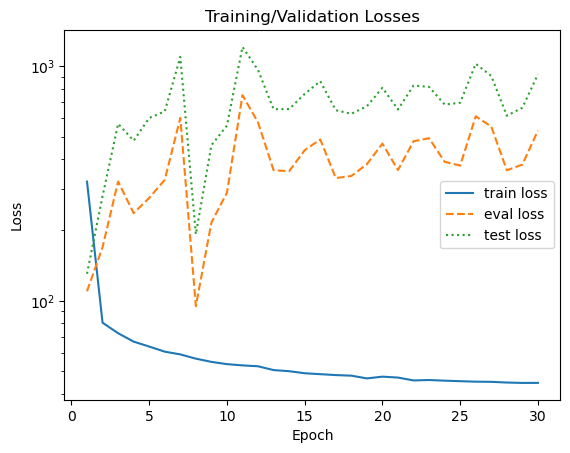

In [606]:
trainer.plot_losses()

## Evaluation on the test set

In [607]:
df_test, df_out = trainer.eval_rul_prediction(LOADERS[-1])

Evaluating test RUL...
Model CNN saved in models/best_model_1103224715.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.20it/s]


In [608]:
df_test

pred  true  unit       err
0       61.511845  58.0    11  3.511845
1       61.438171  58.0    11  3.438171
2       61.368378  58.0    11  3.368378
3       61.237541  58.0    11  3.237541
4       61.169781  58.0    11  3.169781
...           ...   ...   ...       ...
115269   2.886108   0.0    15  2.886108
115270   2.886108   0.0    15  2.886108
115271   2.886108   0.0    15  2.886108
115272   2.886108   0.0    15  2.886108
115273   2.886108   0.0    15  2.886108

[115274 rows x 4 columns]

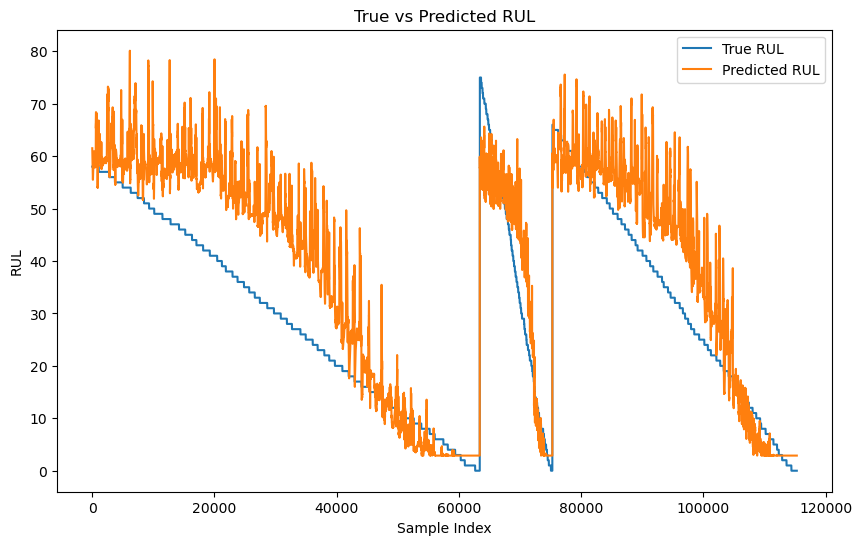

In [609]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['true'], label='True RUL')
plt.plot(df_test['pred'], label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('True vs Predicted RUL')
plt.legend()
plt.show()


In [610]:
# Group predictions by unit
units = df_test['unit'].unique()
for unit in units:
    df_unit = df_test[df_test['unit'] == unit]
    score, rmse = Trainer.evaluate_model_performance(df_unit['pred'], df_unit['true'])
    print(f"Results for Unit {unit}: RMSE = {rmse:.4f}, NASA Score = {score:.4f}")


Results for Unit 11: RMSE = 12.5502, NASA Score = 2.3473
Results for Unit 14: RMSE = 8.7698, NASA Score = 0.2559
Results for Unit 15: RMSE = 9.6639, NASA Score = 1.0602


## Aggregate results of multiple runs

In [611]:
def run_single(seed, model_class, params=DEFAULT_PARAMS, use_batch_norm=False, use_dropout=False, model_params=None):
    if model_params is None:
        model_params = {}
    seed_everything(seed)

    model = model_class(
        in_channels=params['in_channels'],
        out_channels=params['out_channels'],
        window=params['window'],
        n_ch=params['n_ch'],
        n_k=params['n_k'],
        n_hidden=params['n_hidden'],
        dropout=params['dropout'],
        use_batch_norm=use_batch_norm,
        use_dropout=use_dropout,
        **model_params
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['base_lr'],
        weight_decay=params['weight_decay'],
    )

    criterion = nn.MSELoss()
    trainer = Trainer(
        model,
        optimizer,
        criterion=criterion,
        n_epochs=params['max_epochs'],
        seed=seed,
        device=device
    )

    trainer.fit(LOADERS)
    df_eval, df_eval_out = trainer.eval_rul_prediction(LOADERS[1])
    df_test, df_test_out = trainer.eval_rul_prediction(LOADERS[2])
    return df_eval, df_eval_out, df_test, df_test_out


In [612]:
configurations = [
    {'model_class': CNN, 'use_batch_norm': False, 'use_dropout': False, 'name': 'Baseline'},
    {'model_class': CNN, 'use_batch_norm': True, 'use_dropout': False, 'name': 'BatchNorm'},
    {'model_class': CNN, 'use_batch_norm': False, 'use_dropout': True, 'name': 'Dropout'},
    {'model_class': CNN, 'use_batch_norm': True, 'use_dropout': True, 'name': 'BatchNorm+Dropout'},
    {'model_class': CNN_LSTM, 'use_batch_norm': True, 'use_dropout': True, 'name': 'CNN-LSTM','model_params': {'lstm_hidden_size': 50, 'lstm_num_layers': 1}},
    {'model_class': CNN_Dilated, 'use_batch_norm': True, 'use_dropout': True, 'name': 'DilatedCNN'}
]

In [613]:
N_RUNS = 5
results = {}

for config in configurations:
    config_name = config['name']
    print(f"\nRunning configuration: {config_name}")
    df_all_metrics = pd.DataFrame()
    df_all_predictions = pd.DataFrame()
    trainers = []  # List to store trainer objects
    for seed in range(SEED, SEED + N_RUNS):
        df_eval, df_eval_out, df_test, df_test_out = run_single(
            seed,
            model_class=config['model_class'],
            use_batch_norm=config['use_batch_norm'],
            use_dropout=config['use_dropout'],
            model_params=config.get('model_params', {})
        )
        df_test['config'] = config_name
        df_all_metrics = pd.concat([df_all_metrics, df_test_out], ignore_index=True)
        df_all_predictions = pd.concat([df_all_predictions, df_test], ignore_index=True)
        trainers.append(trainer)  # Store the trainer object

    # Compute mean and standard deviation of RMSE and NASA Score
    rmse_mean = df_all_metrics['rmse'].mean()
    rmse_std = df_all_metrics['rmse'].std()
    score_mean = df_all_metrics['score'].mean()
    score_std = df_all_metrics['score'].std()

    print(f"Aggregate Results for {config_name} over {N_RUNS} runs:")
    print(f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
    print(f"NASA Score: {score_mean:.4f} ± {score_std:.4f}")

    # Store results
    results[config_name] = {
        'metrics': df_all_metrics,
        'predictions': df_all_predictions,
        'trainers': trainers,  # Add trainers to results
        'rmse_mean': rmse_mean,
        'rmse_std': rmse_std,
        'score_mean': score_mean,
        'score_std': score_std
    }



Running configuration: Baseline
Training model for 30 epochs...
[Epoch 1] train_loss = 331.89218, eval_loss = 70.45242, test_loss = 115.78341 [126.1s]
[Epoch 2] train_loss = 79.59827, eval_loss = 58.15057, test_loss = 80.25351 [125.0s]
[Epoch 3] train_loss = 71.42478, eval_loss = 59.71184, test_loss = 78.36628 [128.3s]
[Epoch 4] train_loss = 66.35664, eval_loss = 58.34364, test_loss = 141.34534 [127.7s]
[Epoch 5] train_loss = 64.44241, eval_loss = 46.83830, test_loss = 72.13486 [126.6s]
[Epoch 6] train_loss = 64.32403, eval_loss = 72.35178, test_loss = 186.12666 [127.1s]
[Epoch 7] train_loss = 63.56911, eval_loss = 116.41067, test_loss = 277.48718 [125.8s]
[Epoch 8] train_loss = 60.56279, eval_loss = 56.81553, test_loss = 130.60449 [283.1s]
[Epoch 9] train_loss = 60.62400, eval_loss = 50.74756, test_loss = 53.35273 [1125.7s]
[Epoch 10] train_loss = 60.57692, eval_loss = 87.31303, test_loss = 111.11385 [125.7s]
[Epoch 11] train_loss = 60.03901, eval_loss = 81.98923, test_loss = 67.2640

100%|██████████| 394/394 [00:12<00:00, 32.18it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1103235354.pt loaded to cpu


100%|██████████| 451/451 [00:13<00:00, 33.50it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 342.53922, eval_loss = 79.24789, test_loss = 86.11422 [126.1s]
[Epoch 2] train_loss = 75.51654, eval_loss = 53.09166, test_loss = 91.36122 [126.2s]
[Epoch 3] train_loss = 68.17645, eval_loss = 51.92384, test_loss = 98.34187 [126.7s]
[Epoch 4] train_loss = 66.00426, eval_loss = 53.12391, test_loss = 84.82954 [125.0s]
[Epoch 5] train_loss = 64.88797, eval_loss = 77.45049, test_loss = 192.85217 [125.3s]
[Epoch 6] train_loss = 63.80724, eval_loss = 45.83667, test_loss = 67.56070 [125.8s]
[Epoch 7] train_loss = 62.39018, eval_loss = 45.14386, test_loss = 86.94366 [125.8s]
[Epoch 8] train_loss = 63.70789, eval_loss = 60.94940, test_loss = 69.36897 [126.1s]
[Epoch 9] train_loss = 63.27613, eval_loss = 50.26208, test_loss = 84.78336 [126.0s]
[Epoch 10] train_loss = 59.81471, eval_loss = 52.23716, test_loss = 102.32639 [125.9s]
[Epoch 11] train_loss = 60.31037, eval_loss = 48.34913, test_loss = 58.31656 [126.7s]
[Epoch 12] train_loss = 62.4

100%|██████████| 394/394 [00:12<00:00, 32.56it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104020344.pt loaded to cpu


100%|██████████| 451/451 [00:13<00:00, 33.72it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 327.70593, eval_loss = 110.37619, test_loss = 95.83678 [126.6s]
[Epoch 2] train_loss = 80.75963, eval_loss = 94.40399, test_loss = 74.69182 [1026.5s]
[Epoch 3] train_loss = 71.90975, eval_loss = 92.08207, test_loss = 242.10979 [125.1s]
[Epoch 4] train_loss = 69.35626, eval_loss = 79.12665, test_loss = 204.90488 [125.4s]
[Epoch 5] train_loss = 68.47770, eval_loss = 60.95586, test_loss = 129.75603 [125.7s]
[Epoch 6] train_loss = 68.34489, eval_loss = 54.11212, test_loss = 131.69565 [1092.7s]
[Epoch 7] train_loss = 67.60046, eval_loss = 130.86382, test_loss = 322.65576 [368.2s]
[Epoch 8] train_loss = 67.41661, eval_loss = 44.20143, test_loss = 89.36725 [125.9s]
[Epoch 9] train_loss = 63.58869, eval_loss = 53.69453, test_loss = 60.82703 [1983.0s]
[Epoch 10] train_loss = 63.73328, eval_loss = 43.23737, test_loss = 92.83447 [131.8s]
[Epoch 11] train_loss = 62.15935, eval_loss = 58.21325, test_loss = 160.01932 [1135.5s]
[Epoch 12] train_l

100%|██████████| 394/394 [00:12<00:00, 32.53it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104043323.pt loaded to cpu


100%|██████████| 451/451 [00:13<00:00, 33.77it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 333.92975, eval_loss = 89.77420, test_loss = 83.25782 [482.3s]
[Epoch 2] train_loss = 92.53131, eval_loss = 58.79856, test_loss = 100.23819 [126.0s]
[Epoch 3] train_loss = 85.08818, eval_loss = 124.85978, test_loss = 278.34766 [473.8s]
[Epoch 4] train_loss = 71.74702, eval_loss = 54.62584, test_loss = 58.22634 [125.6s]
[Epoch 5] train_loss = 79.08244, eval_loss = 95.12241, test_loss = 238.92781 [125.9s]
[Epoch 6] train_loss = 67.68953, eval_loss = 50.17582, test_loss = 61.84117 [125.2s]
[Epoch 7] train_loss = 66.91402, eval_loss = 49.30037, test_loss = 92.47015 [125.5s]
[Epoch 8] train_loss = 68.93831, eval_loss = 63.08803, test_loss = 52.36914 [126.0s]
[Epoch 9] train_loss = 63.56009, eval_loss = 63.29390, test_loss = 157.55763 [126.6s]
[Epoch 10] train_loss = 66.62309, eval_loss = 67.40353, test_loss = 167.53413 [126.0s]
[Epoch 11] train_loss = 62.09207, eval_loss = 82.37295, test_loss = 74.97926 [124.8s]
[Epoch 12] train_loss = 

100%|██████████| 394/394 [00:12<00:00, 30.37it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104080758.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.13it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 373.65103, eval_loss = 73.63179, test_loss = 78.11853 [126.6s]
[Epoch 2] train_loss = 82.59449, eval_loss = 137.42342, test_loss = 123.93783 [127.1s]
[Epoch 3] train_loss = 71.96898, eval_loss = 130.38892, test_loss = 142.42331 [126.4s]
[Epoch 4] train_loss = 69.49841, eval_loss = 61.78127, test_loss = 123.74614 [127.1s]
[Epoch 5] train_loss = 68.25590, eval_loss = 96.30981, test_loss = 248.14920 [126.3s]
[Epoch 6] train_loss = 65.67796, eval_loss = 65.50936, test_loss = 175.63058 [124.2s]
[Epoch 7] train_loss = 67.07133, eval_loss = 57.73277, test_loss = 151.83362 [125.0s]
[Epoch 8] train_loss = 64.79291, eval_loss = 46.89921, test_loss = 73.51936 [125.6s]
[Epoch 9] train_loss = 61.28712, eval_loss = 126.98229, test_loss = 153.17097 [127.0s]
[Epoch 10] train_loss = 63.30072, eval_loss = 54.62174, test_loss = 80.21460 [131.6s]
[Epoch 11] train_loss = 62.00720, eval_loss = 90.07911, test_loss = 238.03204 [128.0s]
[Epoch 12] train_lo

100%|██████████| 394/394 [00:12<00:00, 30.62it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104100316.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.02it/s]


Aggregate Results for Baseline over 5 runs:
RMSE: 6.7097 ± 0.3017
NASA Score: 2.1170 ± 0.0776

Running configuration: BatchNorm
Training model for 30 epochs...
[Epoch 1] train_loss = 296.05569, eval_loss = 172.47456, test_loss = 244.65541 [127.6s]
[Epoch 2] train_loss = 55.22813, eval_loss = 49.69471, test_loss = 88.38258 [126.6s]
[Epoch 3] train_loss = 51.81158, eval_loss = 162.05069, test_loss = 344.80463 [126.6s]
[Epoch 4] train_loss = 50.69011, eval_loss = 75.92831, test_loss = 107.10577 [132.1s]
[Epoch 5] train_loss = 49.01598, eval_loss = 269.29568, test_loss = 221.25864 [128.7s]
[Epoch 6] train_loss = 46.93858, eval_loss = 137.14749, test_loss = 350.63455 [126.6s]
[Epoch 7] train_loss = 46.28931, eval_loss = 61.46303, test_loss = 92.10490 [127.7s]
[Epoch 8] train_loss = 44.91220, eval_loss = 55.28693, test_loss = 165.00375 [128.1s]
[Epoch 9] train_loss = 43.95351, eval_loss = 66.49915, test_loss = 99.85385 [129.8s]
[Epoch 10] train_loss = 43.81298, eval_loss = 54.23264, test_los

100%|██████████| 394/394 [00:13<00:00, 30.16it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104110657.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.61it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 349.01425, eval_loss = 314.39703, test_loss = 622.07031 [127.4s]
[Epoch 2] train_loss = 52.35477, eval_loss = 186.96838, test_loss = 497.09686 [127.4s]
[Epoch 3] train_loss = 50.06279, eval_loss = 101.67938, test_loss = 268.61581 [128.0s]
[Epoch 4] train_loss = 49.41167, eval_loss = 91.08808, test_loss = 207.30161 [129.0s]
[Epoch 5] train_loss = 47.14725, eval_loss = 68.84255, test_loss = 76.14068 [127.9s]
[Epoch 6] train_loss = 46.64038, eval_loss = 73.46613, test_loss = 85.21440 [130.0s]
[Epoch 7] train_loss = 45.85378, eval_loss = 113.09382, test_loss = 350.61877 [127.9s]
[Epoch 8] train_loss = 44.92071, eval_loss = 119.38588, test_loss = 142.42938 [128.3s]
[Epoch 9] train_loss = 44.44994, eval_loss = 115.83194, test_loss = 252.72475 [128.7s]
[Epoch 10] train_loss = 44.24871, eval_loss = 173.15981, test_loss = 126.28173 [128.9s]
[Epoch 11] train_loss = 43.76676, eval_loss = 101.86438, test_loss = 129.57362 [128.4s]
[Epoch 12] tr

100%|██████████| 394/394 [00:12<00:00, 30.79it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104121152.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.05it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 304.67261, eval_loss = 287.04770, test_loss = 532.89685 [128.3s]
[Epoch 2] train_loss = 57.03216, eval_loss = 62.52048, test_loss = 57.91311 [129.1s]
[Epoch 3] train_loss = 51.34411, eval_loss = 127.07763, test_loss = 87.63491 [128.7s]
[Epoch 4] train_loss = 48.76307, eval_loss = 151.23343, test_loss = 363.43997 [129.6s]
[Epoch 5] train_loss = 46.40102, eval_loss = 136.37282, test_loss = 355.35791 [127.7s]
[Epoch 6] train_loss = 45.78809, eval_loss = 74.69103, test_loss = 58.52358 [127.7s]
[Epoch 7] train_loss = 45.82225, eval_loss = 171.89893, test_loss = 192.12148 [127.1s]
[Epoch 8] train_loss = 44.52735, eval_loss = 68.23431, test_loss = 51.36580 [129.4s]
[Epoch 9] train_loss = 44.52875, eval_loss = 57.73539, test_loss = 50.95144 [128.2s]
[Epoch 10] train_loss = 43.95169, eval_loss = 78.79823, test_loss = 204.13742 [129.4s]
[Epoch 11] train_loss = 42.86395, eval_loss = 39.27363, test_loss = 90.69294 [127.8s]
[Epoch 12] train_los

100%|██████████| 394/394 [00:12<00:00, 30.40it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104131642.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.32it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 307.95398, eval_loss = 268.79581, test_loss = 535.67224 [127.4s]
[Epoch 2] train_loss = 53.38369, eval_loss = 150.53255, test_loss = 305.97830 [129.9s]
[Epoch 3] train_loss = 49.55474, eval_loss = 401.82443, test_loss = 418.45126 [131.4s]
[Epoch 4] train_loss = 48.02095, eval_loss = 48.25679, test_loss = 114.32198 [128.9s]
[Epoch 5] train_loss = 46.76852, eval_loss = 278.52829, test_loss = 580.67371 [127.4s]
[Epoch 6] train_loss = 45.50695, eval_loss = 305.65079, test_loss = 286.32040 [127.8s]
[Epoch 7] train_loss = 45.16722, eval_loss = 59.05965, test_loss = 161.43274 [127.4s]
[Epoch 8] train_loss = 44.33998, eval_loss = 235.29538, test_loss = 289.74786 [128.0s]
[Epoch 9] train_loss = 43.37019, eval_loss = 46.31387, test_loss = 65.81479 [127.1s]
[Epoch 10] train_loss = 42.47096, eval_loss = 45.91586, test_loss = 130.97868 [128.1s]
[Epoch 11] train_loss = 42.82516, eval_loss = 46.04277, test_loss = 113.74773 [128.1s]
[Epoch 12] tra

100%|██████████| 394/394 [00:12<00:00, 31.14it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104142143.pt loaded to cpu


100%|██████████| 451/451 [00:13<00:00, 32.59it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 291.33875, eval_loss = 68.48970, test_loss = 164.86169 [126.3s]
[Epoch 2] train_loss = 53.95276, eval_loss = 107.87761, test_loss = 160.48756 [131.7s]
[Epoch 3] train_loss = 51.00368, eval_loss = 247.38158, test_loss = 497.75058 [129.0s]
[Epoch 4] train_loss = 48.41052, eval_loss = 203.15077, test_loss = 414.03052 [130.6s]
[Epoch 5] train_loss = 47.34433, eval_loss = 41.61616, test_loss = 68.31892 [128.6s]
[Epoch 6] train_loss = 46.52859, eval_loss = 242.63550, test_loss = 193.15108 [132.6s]
[Epoch 7] train_loss = 45.83319, eval_loss = 90.49611, test_loss = 148.14198 [133.6s]
[Epoch 8] train_loss = 44.84544, eval_loss = 95.49827, test_loss = 157.12816 [129.6s]
[Epoch 9] train_loss = 43.98489, eval_loss = 162.50899, test_loss = 379.31436 [127.7s]
[Epoch 10] train_loss = 42.63301, eval_loss = 77.08817, test_loss = 69.29896 [130.0s]
[Epoch 11] train_loss = 43.42423, eval_loss = 153.91714, test_loss = 405.00143 [128.7s]
[Epoch 12] trai

100%|██████████| 394/394 [00:12<00:00, 30.86it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104152636.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.02it/s]


Aggregate Results for BatchNorm over 5 runs:
RMSE: 7.1849 ± 0.7597
NASA Score: 2.2389 ± 0.2182

Running configuration: Dropout
Training model for 30 epochs...
[Epoch 1] train_loss = 327.71298, eval_loss = 84.58572, test_loss = 116.11195 [129.3s]
[Epoch 2] train_loss = 116.40764, eval_loss = 93.87151, test_loss = 113.63070 [128.5s]
[Epoch 3] train_loss = 101.46179, eval_loss = 60.31961, test_loss = 96.55285 [128.0s]
[Epoch 4] train_loss = 95.40594, eval_loss = 87.97369, test_loss = 63.61756 [128.0s]
[Epoch 5] train_loss = 87.94925, eval_loss = 89.43914, test_loss = 212.61150 [132.3s]
[Epoch 6] train_loss = 84.65705, eval_loss = 60.23909, test_loss = 98.91527 [130.1s]
[Epoch 7] train_loss = 79.94566, eval_loss = 83.18095, test_loss = 77.60581 [128.4s]
[Epoch 8] train_loss = 80.41413, eval_loss = 136.44041, test_loss = 99.39890 [129.0s]
[Epoch 9] train_loss = 75.69262, eval_loss = 69.59587, test_loss = 58.41805 [129.2s]
[Epoch 10] train_loss = 74.98429, eval_loss = 56.75787, test_loss = 1

100%|██████████| 394/394 [00:12<00:00, 31.74it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104163138.pt loaded to cpu


100%|██████████| 451/451 [00:13<00:00, 32.65it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 395.04300, eval_loss = 109.74151, test_loss = 83.50051 [127.3s]
[Epoch 2] train_loss = 115.68824, eval_loss = 68.38496, test_loss = 86.09782 [128.7s]
[Epoch 3] train_loss = 104.62122, eval_loss = 63.16471, test_loss = 78.21255 [128.2s]
[Epoch 4] train_loss = 98.34305, eval_loss = 84.88932, test_loss = 87.12579 [130.0s]
[Epoch 5] train_loss = 94.75224, eval_loss = 75.33432, test_loss = 76.16570 [126.7s]
[Epoch 6] train_loss = 89.79818, eval_loss = 98.13939, test_loss = 75.54537 [129.3s]
[Epoch 7] train_loss = 86.90979, eval_loss = 61.31277, test_loss = 117.10711 [126.9s]
[Epoch 8] train_loss = 84.13284, eval_loss = 62.84216, test_loss = 66.97029 [128.3s]
[Epoch 9] train_loss = 83.22720, eval_loss = 59.69880, test_loss = 115.04430 [126.3s]
[Epoch 10] train_loss = 79.42918, eval_loss = 53.93956, test_loss = 92.05878 [144.9s]
[Epoch 11] train_loss = 80.40513, eval_loss = 61.15228, test_loss = 73.24899 [135.9s]
[Epoch 12] train_loss = 7

100%|██████████| 394/394 [00:13<00:00, 28.41it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104173633.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 30.48it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 365.35831, eval_loss = 98.24090, test_loss = 179.64630 [136.0s]
[Epoch 2] train_loss = 125.51720, eval_loss = 110.75661, test_loss = 236.53287 [137.1s]
[Epoch 3] train_loss = 109.66254, eval_loss = 83.21410, test_loss = 71.80038 [135.1s]
[Epoch 4] train_loss = 103.55392, eval_loss = 200.01105, test_loss = 194.03557 [133.2s]
[Epoch 5] train_loss = 101.77886, eval_loss = 71.02335, test_loss = 90.56107 [131.8s]
[Epoch 6] train_loss = 96.31118, eval_loss = 105.73027, test_loss = 96.48610 [132.7s]
[Epoch 7] train_loss = 93.88774, eval_loss = 69.82797, test_loss = 85.23220 [1051.7s]
[Epoch 8] train_loss = 90.27818, eval_loss = 75.51463, test_loss = 67.90285 [130.2s]
[Epoch 9] train_loss = 89.18826, eval_loss = 134.66101, test_loss = 119.45127 [128.3s]
[Epoch 10] train_loss = 84.71919, eval_loss = 106.69617, test_loss = 76.53069 [668.3s]
[Epoch 11] train_loss = 82.16231, eval_loss = 82.16120, test_loss = 181.92934 [1082.3s]
[Epoch 12] tra

100%|██████████| 394/394 [00:12<00:00, 31.18it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104184338.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.85it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 397.16257, eval_loss = 176.37703, test_loss = 120.14186 [129.4s]
[Epoch 2] train_loss = 130.46617, eval_loss = 144.62103, test_loss = 105.91394 [130.4s]
[Epoch 3] train_loss = 117.11016, eval_loss = 119.50430, test_loss = 258.54895 [130.3s]
[Epoch 4] train_loss = 107.98379, eval_loss = 117.73210, test_loss = 81.24789 [129.8s]
[Epoch 5] train_loss = 102.21520, eval_loss = 205.35515, test_loss = 177.00858 [128.5s]
[Epoch 6] train_loss = 95.55612, eval_loss = 115.55884, test_loss = 101.81122 [129.1s]
[Epoch 7] train_loss = 89.01007, eval_loss = 102.10471, test_loss = 76.50748 [129.4s]
[Epoch 8] train_loss = 86.03379, eval_loss = 78.51331, test_loss = 72.74551 [130.0s]
[Epoch 9] train_loss = 83.20110, eval_loss = 102.34145, test_loss = 87.61990 [130.7s]
[Epoch 10] train_loss = 80.23825, eval_loss = 72.66710, test_loss = 68.32477 [129.2s]
[Epoch 11] train_loss = 80.13950, eval_loss = 100.33604, test_loss = 74.82490 [130.2s]
[Epoch 12] t

100%|██████████| 394/394 [00:12<00:00, 31.00it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104203630.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.00it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 367.52908, eval_loss = 192.39935, test_loss = 170.28513 [128.6s]
[Epoch 2] train_loss = 117.41114, eval_loss = 81.36337, test_loss = 93.52460 [129.9s]
[Epoch 3] train_loss = 103.83810, eval_loss = 62.16238, test_loss = 75.17081 [129.7s]
[Epoch 4] train_loss = 94.04046, eval_loss = 141.55141, test_loss = 116.89624 [129.4s]
[Epoch 5] train_loss = 89.58017, eval_loss = 60.21393, test_loss = 94.30650 [128.7s]
[Epoch 6] train_loss = 85.64032, eval_loss = 212.69005, test_loss = 185.39520 [130.2s]
[Epoch 7] train_loss = 82.05338, eval_loss = 83.45354, test_loss = 75.90703 [130.7s]
[Epoch 8] train_loss = 77.25667, eval_loss = 79.19690, test_loss = 76.71917 [128.9s]
[Epoch 9] train_loss = 75.18172, eval_loss = 74.35548, test_loss = 58.94057 [129.1s]
[Epoch 10] train_loss = 75.34934, eval_loss = 77.93481, test_loss = 184.63504 [128.5s]
[Epoch 11] train_loss = 72.93160, eval_loss = 62.21627, test_loss = 71.30746 [128.0s]
[Epoch 12] train_loss

100%|██████████| 394/394 [00:12<00:00, 30.49it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104214156.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.02it/s]


Aggregate Results for Dropout over 5 runs:
RMSE: 6.9551 ± 0.3628
NASA Score: 2.1583 ± 0.0926

Running configuration: BatchNorm+Dropout
Training model for 30 epochs...
[Epoch 1] train_loss = 321.79044, eval_loss = 109.65800, test_loss = 130.21497 [133.3s]
[Epoch 2] train_loss = 80.51729, eval_loss = 169.07744, test_loss = 279.04529 [134.2s]
[Epoch 3] train_loss = 72.61824, eval_loss = 322.16550, test_loss = 567.99536 [129.6s]
[Epoch 4] train_loss = 66.86469, eval_loss = 236.17474, test_loss = 481.23901 [129.3s]
[Epoch 5] train_loss = 63.70645, eval_loss = 274.20087, test_loss = 601.01019 [132.5s]
[Epoch 6] train_loss = 60.59564, eval_loss = 327.51840, test_loss = 641.93109 [131.7s]
[Epoch 7] train_loss = 58.98516, eval_loss = 601.34729, test_loss = 1095.90588 [132.5s]
[Epoch 8] train_loss = 56.56984, eval_loss = 94.75706, test_loss = 191.82332 [131.9s]
[Epoch 9] train_loss = 54.80413, eval_loss = 215.20334, test_loss = 459.72720 [131.9s]
[Epoch 10] train_loss = 53.60591, eval_loss = 288

100%|██████████| 394/394 [00:12<00:00, 31.14it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104224710.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.76it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 372.08963, eval_loss = 128.47792, test_loss = 149.29472 [128.6s]
[Epoch 2] train_loss = 78.08266, eval_loss = 119.23460, test_loss = 152.56235 [129.3s]
[Epoch 3] train_loss = 72.93124, eval_loss = 241.85573, test_loss = 305.48254 [130.4s]
[Epoch 4] train_loss = 67.51078, eval_loss = 300.82611, test_loss = 308.06381 [130.3s]
[Epoch 5] train_loss = 64.75413, eval_loss = 75.37020, test_loss = 75.07829 [135.7s]
[Epoch 6] train_loss = 62.57153, eval_loss = 230.74709, test_loss = 234.03923 [130.9s]
[Epoch 7] train_loss = 61.04109, eval_loss = 111.57666, test_loss = 129.28490 [131.2s]
[Epoch 8] train_loss = 58.29659, eval_loss = 137.20979, test_loss = 273.14056 [131.9s]
[Epoch 9] train_loss = 55.95589, eval_loss = 176.72331, test_loss = 347.80869 [132.8s]
[Epoch 10] train_loss = 54.33644, eval_loss = 149.32214, test_loss = 290.72971 [130.4s]
[Epoch 11] train_loss = 53.12954, eval_loss = 130.37080, test_loss = 219.79861 [131.8s]
[Epoch 12]

100%|██████████| 394/394 [00:12<00:00, 31.59it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1104235323.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 32.16it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 335.67441, eval_loss = 177.93927, test_loss = 204.34872 [129.8s]
[Epoch 2] train_loss = 85.07197, eval_loss = 127.17477, test_loss = 205.69612 [133.4s]
[Epoch 3] train_loss = 73.43211, eval_loss = 277.11902, test_loss = 589.66669 [132.3s]
[Epoch 4] train_loss = 67.16989, eval_loss = 197.10245, test_loss = 392.38876 [132.8s]
[Epoch 5] train_loss = 63.34393, eval_loss = 134.80835, test_loss = 260.98233 [132.8s]
[Epoch 6] train_loss = 60.47020, eval_loss = 262.35135, test_loss = 495.09198 [131.8s]
[Epoch 7] train_loss = 58.15881, eval_loss = 125.62127, test_loss = 250.73099 [133.1s]
[Epoch 8] train_loss = 56.64262, eval_loss = 170.50967, test_loss = 370.42871 [134.4s]
[Epoch 9] train_loss = 54.83120, eval_loss = 260.47305, test_loss = 539.80640 [133.1s]
[Epoch 10] train_loss = 53.85218, eval_loss = 474.12207, test_loss = 836.74414 [133.0s]
[Epoch 11] train_loss = 52.85831, eval_loss = 180.90739, test_loss = 380.72134 [133.5s]
[Epoch 1

100%|██████████| 394/394 [00:13<00:00, 29.87it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1105005904.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.84it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 353.76978, eval_loss = 790.03461, test_loss = 1320.12183 [134.3s]
[Epoch 2] train_loss = 72.02679, eval_loss = 159.62546, test_loss = 347.57410 [133.1s]
[Epoch 3] train_loss = 63.48553, eval_loss = 436.26227, test_loss = 819.43665 [132.9s]
[Epoch 4] train_loss = 61.73978, eval_loss = 364.21173, test_loss = 755.46875 [133.0s]
[Epoch 5] train_loss = 58.82912, eval_loss = 294.27274, test_loss = 621.69055 [133.6s]
[Epoch 6] train_loss = 57.46321, eval_loss = 199.78461, test_loss = 506.57089 [134.0s]
[Epoch 7] train_loss = 56.33826, eval_loss = 351.08032, test_loss = 715.62567 [132.5s]
[Epoch 8] train_loss = 56.31762, eval_loss = 189.17264, test_loss = 454.34351 [132.7s]
[Epoch 9] train_loss = 54.78423, eval_loss = 455.14655, test_loss = 872.89856 [127.2s]
[Epoch 10] train_loss = 54.14091, eval_loss = 209.02013, test_loss = 425.05499 [132.3s]
[Epoch 11] train_loss = 54.09473, eval_loss = 396.08121, test_loss = 735.44360 [134.0s]
[Epoch 

100%|██████████| 394/394 [00:13<00:00, 30.23it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1105020551.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 30.58it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 315.75549, eval_loss = 136.55568, test_loss = 291.53577 [133.7s]
[Epoch 2] train_loss = 71.69617, eval_loss = 250.74458, test_loss = 488.58054 [134.2s]
[Epoch 3] train_loss = 65.53204, eval_loss = 130.57187, test_loss = 275.40439 [132.8s]
[Epoch 4] train_loss = 62.75953, eval_loss = 156.43291, test_loss = 333.24554 [132.0s]
[Epoch 5] train_loss = 60.60480, eval_loss = 283.93896, test_loss = 565.59833 [131.8s]
[Epoch 6] train_loss = 58.60484, eval_loss = 400.27484, test_loss = 770.04340 [131.8s]
[Epoch 7] train_loss = 57.73725, eval_loss = 348.72156, test_loss = 697.90295 [132.9s]
[Epoch 8] train_loss = 56.60949, eval_loss = 311.36353, test_loss = 650.56708 [132.7s]
[Epoch 9] train_loss = 55.55239, eval_loss = 174.64908, test_loss = 346.22742 [131.7s]
[Epoch 10] train_loss = 54.85945, eval_loss = 234.89249, test_loss = 413.95432 [133.6s]
[Epoch 11] train_loss = 55.02677, eval_loss = 278.86185, test_loss = 526.06757 [133.5s]
[Epoch 1

100%|██████████| 394/394 [00:12<00:00, 30.70it/s]


Evaluating test RUL...
Model CNN saved in models/best_model_1105031246.pt loaded to cpu


100%|██████████| 451/451 [00:14<00:00, 31.86it/s]


Aggregate Results for BatchNorm+Dropout over 5 runs:
RMSE: 11.9750 ± 3.0732
NASA Score: 4.2548 ± 1.4957

Running configuration: CNN-LSTM
Training model for 30 epochs...
[Epoch 1] train_loss = 362.18442, eval_loss = 137.93549, test_loss = 218.42130 [156.5s]
[Epoch 2] train_loss = 61.81942, eval_loss = 177.99022, test_loss = 188.34059 [155.9s]
[Epoch 3] train_loss = 57.37748, eval_loss = 233.62531, test_loss = 191.42175 [155.7s]
[Epoch 4] train_loss = 54.43669, eval_loss = 164.59843, test_loss = 391.65424 [154.8s]
[Epoch 5] train_loss = 52.97260, eval_loss = 188.57375, test_loss = 412.25317 [156.0s]
[Epoch 6] train_loss = 51.57492, eval_loss = 171.11249, test_loss = 127.40359 [157.9s]
[Epoch 7] train_loss = 50.03707, eval_loss = 242.06161, test_loss = 575.20294 [157.1s]
[Epoch 8] train_loss = 49.79535, eval_loss = 137.38829, test_loss = 138.36295 [156.1s]
[Epoch 9] train_loss = 48.54624, eval_loss = 207.32475, test_loss = 457.28979 [154.4s]
[Epoch 10] train_loss = 47.74419, eval_loss = 1

100%|██████████| 394/394 [00:15<00:00, 25.71it/s]


Evaluating test RUL...
Model CNN_LSTM saved in models/best_model_1105041930.pt loaded to cpu


100%|██████████| 451/451 [00:17<00:00, 25.96it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 346.31494, eval_loss = 194.28778, test_loss = 153.45418 [152.4s]
[Epoch 2] train_loss = 60.07469, eval_loss = 94.11742, test_loss = 197.45972 [152.7s]
[Epoch 3] train_loss = 55.75063, eval_loss = 61.32355, test_loss = 148.71478 [154.1s]
[Epoch 4] train_loss = 53.10197, eval_loss = 343.21796, test_loss = 297.15042 [152.4s]
[Epoch 5] train_loss = 51.49689, eval_loss = 102.69816, test_loss = 232.05193 [151.8s]
[Epoch 6] train_loss = 49.36649, eval_loss = 130.79480, test_loss = 146.12039 [152.9s]
[Epoch 7] train_loss = 48.46210, eval_loss = 285.06705, test_loss = 201.48036 [153.2s]
[Epoch 8] train_loss = 47.53936, eval_loss = 362.16632, test_loss = 305.29028 [152.3s]
[Epoch 9] train_loss = 46.60995, eval_loss = 131.27379, test_loss = 278.06631 [153.6s]
[Epoch 10] train_loss = 46.48766, eval_loss = 178.55202, test_loss = 129.01904 [152.5s]
[Epoch 11] train_loss = 45.68798, eval_loss = 169.68092, test_loss = 153.58447 [152.4s]
[Epoch 12]

100%|██████████| 394/394 [00:15<00:00, 25.01it/s]


Evaluating test RUL...
Model CNN_LSTM saved in models/best_model_1105053711.pt loaded to cpu


100%|██████████| 451/451 [00:17<00:00, 26.21it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 338.98587, eval_loss = 127.59959, test_loss = 100.11202 [152.0s]
[Epoch 2] train_loss = 59.85043, eval_loss = 93.10793, test_loss = 250.24869 [151.8s]
[Epoch 3] train_loss = 53.36059, eval_loss = 176.42003, test_loss = 408.22406 [153.4s]
[Epoch 4] train_loss = 51.15084, eval_loss = 239.26753, test_loss = 454.40009 [152.5s]
[Epoch 5] train_loss = 48.87162, eval_loss = 124.72076, test_loss = 135.22238 [152.1s]
[Epoch 6] train_loss = 48.37505, eval_loss = 211.25027, test_loss = 277.92288 [153.7s]
[Epoch 7] train_loss = 47.28149, eval_loss = 134.96851, test_loss = 132.57269 [153.1s]
[Epoch 8] train_loss = 46.52150, eval_loss = 168.25540, test_loss = 326.64362 [152.5s]
[Epoch 9] train_loss = 46.31678, eval_loss = 225.20839, test_loss = 474.71213 [152.6s]
[Epoch 10] train_loss = 45.31871, eval_loss = 144.59126, test_loss = 252.14630 [152.4s]
[Epoch 11] train_loss = 44.96267, eval_loss = 216.09081, test_loss = 348.45377 [154.7s]
[Epoch 12

100%|██████████| 394/394 [00:15<00:00, 25.66it/s]


Evaluating test RUL...
Model CNN_LSTM saved in models/best_model_1105065403.pt loaded to cpu


100%|██████████| 451/451 [00:16<00:00, 26.86it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 396.57330, eval_loss = 112.93987, test_loss = 109.11868 [154.1s]
[Epoch 2] train_loss = 63.53407, eval_loss = 325.50613, test_loss = 272.74063 [152.8s]
[Epoch 3] train_loss = 56.09110, eval_loss = 377.86005, test_loss = 349.60229 [151.7s]
[Epoch 4] train_loss = 52.63668, eval_loss = 466.26038, test_loss = 445.20676 [153.9s]
[Epoch 5] train_loss = 51.21336, eval_loss = 300.30386, test_loss = 219.33701 [152.2s]
[Epoch 6] train_loss = 49.40205, eval_loss = 72.32578, test_loss = 106.13245 [153.1s]
[Epoch 7] train_loss = 48.35815, eval_loss = 521.55634, test_loss = 447.27158 [153.1s]
[Epoch 8] train_loss = 47.24962, eval_loss = 246.07860, test_loss = 175.23073 [151.9s]
[Epoch 9] train_loss = 46.24994, eval_loss = 221.10838, test_loss = 194.35551 [152.3s]
[Epoch 10] train_loss = 45.82280, eval_loss = 202.32991, test_loss = 142.54565 [152.3s]
[Epoch 11] train_loss = 45.72145, eval_loss = 265.36029, test_loss = 191.67249 [152.3s]
[Epoch 12

100%|██████████| 394/394 [00:15<00:00, 25.39it/s]


Evaluating test RUL...
Model CNN_LSTM saved in models/best_model_1105081102.pt loaded to cpu


100%|██████████| 451/451 [00:16<00:00, 26.79it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 419.25787, eval_loss = 209.93350, test_loss = 223.48734 [152.0s]
[Epoch 2] train_loss = 61.61841, eval_loss = 103.99648, test_loss = 201.13069 [153.0s]
[Epoch 3] train_loss = 54.42415, eval_loss = 301.84766, test_loss = 232.87280 [153.8s]
[Epoch 4] train_loss = 52.74935, eval_loss = 92.59089, test_loss = 154.09853 [152.8s]
[Epoch 5] train_loss = 50.62017, eval_loss = 185.16609, test_loss = 137.57779 [153.8s]
[Epoch 6] train_loss = 49.20863, eval_loss = 152.01926, test_loss = 146.59517 [152.0s]
[Epoch 7] train_loss = 48.03479, eval_loss = 163.64384, test_loss = 173.36595 [154.6s]
[Epoch 8] train_loss = 47.33786, eval_loss = 126.45396, test_loss = 140.80121 [153.4s]
[Epoch 9] train_loss = 46.36424, eval_loss = 154.70999, test_loss = 141.47528 [152.6s]
[Epoch 10] train_loss = 46.81337, eval_loss = 93.47170, test_loss = 154.18982 [152.8s]
[Epoch 11] train_loss = 44.86670, eval_loss = 298.36523, test_loss = 589.29327 [152.6s]
[Epoch 12]

100%|██████████| 394/394 [00:16<00:00, 23.96it/s]


Evaluating test RUL...
Model CNN_LSTM saved in models/best_model_1105092759.pt loaded to cpu


100%|██████████| 451/451 [00:17<00:00, 25.34it/s]


Aggregate Results for CNN-LSTM over 5 runs:
RMSE: 10.0617 ± 2.0191
NASA Score: 3.2472 ± 0.8438

Running configuration: DilatedCNN
Training model for 30 epochs...
[Epoch 1] train_loss = 177.83917, eval_loss = 167.87102, test_loss = 236.31863 [157.7s]
[Epoch 2] train_loss = 65.36388, eval_loss = 182.62758, test_loss = 174.25909 [158.7s]
[Epoch 3] train_loss = 58.95967, eval_loss = 155.05447, test_loss = 112.17060 [159.1s]
[Epoch 4] train_loss = 56.45559, eval_loss = 86.11894, test_loss = 187.08336 [156.9s]
[Epoch 5] train_loss = 55.04156, eval_loss = 71.08900, test_loss = 139.43263 [158.6s]
[Epoch 6] train_loss = 53.18124, eval_loss = 120.75491, test_loss = 117.92376 [158.2s]
[Epoch 7] train_loss = 50.99325, eval_loss = 78.36961, test_loss = 128.65517 [156.0s]
[Epoch 8] train_loss = 50.06856, eval_loss = 65.33222, test_loss = 111.79105 [155.9s]
[Epoch 9] train_loss = 48.71347, eval_loss = 159.55675, test_loss = 146.35979 [155.5s]
[Epoch 10] train_loss = 47.89875, eval_loss = 96.30799, te

100%|██████████| 394/394 [00:45<00:00,  8.70it/s]


Evaluating test RUL...
Model CNN_Dilated saved in models/best_model_1105104503.pt loaded to cpu


100%|██████████| 451/451 [00:23<00:00, 19.44it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 187.77110, eval_loss = 452.95624, test_loss = 410.69888 [1063.5s]
[Epoch 2] train_loss = 63.45512, eval_loss = 382.12387, test_loss = 291.01065 [197.6s]
[Epoch 3] train_loss = 59.82686, eval_loss = 214.42015, test_loss = 225.77602 [195.1s]
[Epoch 4] train_loss = 56.70236, eval_loss = 132.22527, test_loss = 286.22766 [194.7s]
[Epoch 5] train_loss = 54.52658, eval_loss = 269.11157, test_loss = 217.97870 [6714.5s]
[Epoch 6] train_loss = 52.99473, eval_loss = 142.82024, test_loss = 150.54741 [378.8s]
[Epoch 7] train_loss = 52.25053, eval_loss = 195.47400, test_loss = 186.46318 [381.3s]
[Epoch 8] train_loss = 50.51066, eval_loss = 176.09488, test_loss = 183.69537 [200.3s]
[Epoch 9] train_loss = 48.64086, eval_loss = 215.61069, test_loss = 296.83466 [205.6s]
[Epoch 10] train_loss = 48.02585, eval_loss = 215.79665, test_loss = 201.65247 [197.1s]
[Epoch 11] train_loss = 47.63306, eval_loss = 198.87918, test_loss = 270.97382 [198.1s]
[Epoch

100%|██████████| 394/394 [00:16<00:00, 23.20it/s]


Evaluating test RUL...
Model CNN_Dilated saved in models/best_model_1105123637.pt loaded to cpu


100%|██████████| 451/451 [00:18<00:00, 24.61it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 189.74843, eval_loss = 250.46451, test_loss = 337.92978 [161.3s]
[Epoch 2] train_loss = 63.51263, eval_loss = 114.10302, test_loss = 223.80852 [163.8s]
[Epoch 3] train_loss = 57.39696, eval_loss = 179.37129, test_loss = 386.64859 [164.1s]
[Epoch 4] train_loss = 55.92382, eval_loss = 239.66728, test_loss = 176.32391 [159.2s]
[Epoch 5] train_loss = 54.87885, eval_loss = 157.64226, test_loss = 337.69980 [206.1s]
[Epoch 6] train_loss = 53.12803, eval_loss = 124.11343, test_loss = 296.37030 [206.4s]
[Epoch 7] train_loss = 50.89933, eval_loss = 97.63889, test_loss = 159.41130 [208.0s]
[Epoch 8] train_loss = 51.37175, eval_loss = 175.74951, test_loss = 404.16937 [204.1s]
[Epoch 9] train_loss = 49.70596, eval_loss = 254.45073, test_loss = 597.28497 [199.5s]
[Epoch 10] train_loss = 48.49188, eval_loss = 202.44948, test_loss = 201.05257 [207.3s]
[Epoch 11] train_loss = 47.64387, eval_loss = 253.88078, test_loss = 543.12433 [204.4s]
[Epoch 12

100%|██████████| 394/394 [00:22<00:00, 17.14it/s]


Evaluating test RUL...
Model CNN_Dilated saved in models/best_model_1105161336.pt loaded to cpu


100%|██████████| 451/451 [00:25<00:00, 17.74it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 190.90288, eval_loss = 151.96176, test_loss = 103.09060 [210.9s]
[Epoch 2] train_loss = 64.40903, eval_loss = 378.00977, test_loss = 378.89114 [203.5s]
[Epoch 3] train_loss = 58.14964, eval_loss = 164.47214, test_loss = 158.56508 [208.9s]
[Epoch 4] train_loss = 55.37092, eval_loss = 217.66261, test_loss = 180.56567 [207.2s]
[Epoch 5] train_loss = 53.17323, eval_loss = 126.65717, test_loss = 126.08515 [219.8s]
[Epoch 6] train_loss = 51.60889, eval_loss = 152.23930, test_loss = 230.59360 [225.6s]
[Epoch 7] train_loss = 51.69365, eval_loss = 153.63156, test_loss = 177.51495 [217.9s]
[Epoch 8] train_loss = 50.76083, eval_loss = 141.75305, test_loss = 164.33531 [211.9s]
[Epoch 9] train_loss = 49.42794, eval_loss = 167.56993, test_loss = 332.37259 [207.3s]
[Epoch 10] train_loss = 48.76719, eval_loss = 158.20923, test_loss = 143.39937 [209.5s]
[Epoch 11] train_loss = 48.71550, eval_loss = 142.57469, test_loss = 261.45285 [211.9s]
[Epoch 1

100%|██████████| 394/394 [00:16<00:00, 23.19it/s]


Evaluating test RUL...
Model CNN_Dilated saved in models/best_model_1105175423.pt loaded to cpu


100%|██████████| 451/451 [00:18<00:00, 24.50it/s]


Training model for 30 epochs...
[Epoch 1] train_loss = 185.57616, eval_loss = 541.83704, test_loss = 475.05508 [161.7s]
[Epoch 2] train_loss = 65.93007, eval_loss = 573.21228, test_loss = 474.44196 [159.8s]
[Epoch 3] train_loss = 59.51532, eval_loss = 401.61777, test_loss = 332.48129 [301.6s]
[Epoch 4] train_loss = 56.56249, eval_loss = 153.17839, test_loss = 203.57787 [322.0s]
[Epoch 5] train_loss = 55.77107, eval_loss = 175.47685, test_loss = 162.97243 [5694.3s]
[Epoch 6] train_loss = 53.75079, eval_loss = 342.94669, test_loss = 279.32309 [4743.4s]
[Epoch 7] train_loss = 52.62314, eval_loss = 234.04573, test_loss = 185.03938 [157.9s]
[Epoch 8] train_loss = 51.25948, eval_loss = 282.20291, test_loss = 229.12451 [158.8s]
[Epoch 9] train_loss = 49.81250, eval_loss = 298.80798, test_loss = 251.25845 [157.1s]
[Epoch 10] train_loss = 48.14206, eval_loss = 157.09746, test_loss = 170.04890 [157.6s]
[Epoch 11] train_loss = 47.99764, eval_loss = 195.24898, test_loss = 153.74355 [160.1s]
[Epoch

100%|██████████| 394/394 [00:16<00:00, 24.12it/s]


Evaluating test RUL...
Model CNN_Dilated saved in models/best_model_1105193135.pt loaded to cpu


100%|██████████| 451/451 [00:18<00:00, 24.69it/s]

Aggregate Results for DilatedCNN over 5 runs:
RMSE: 10.8054 ± 1.8792
NASA Score: 3.5864 ± 1.0135


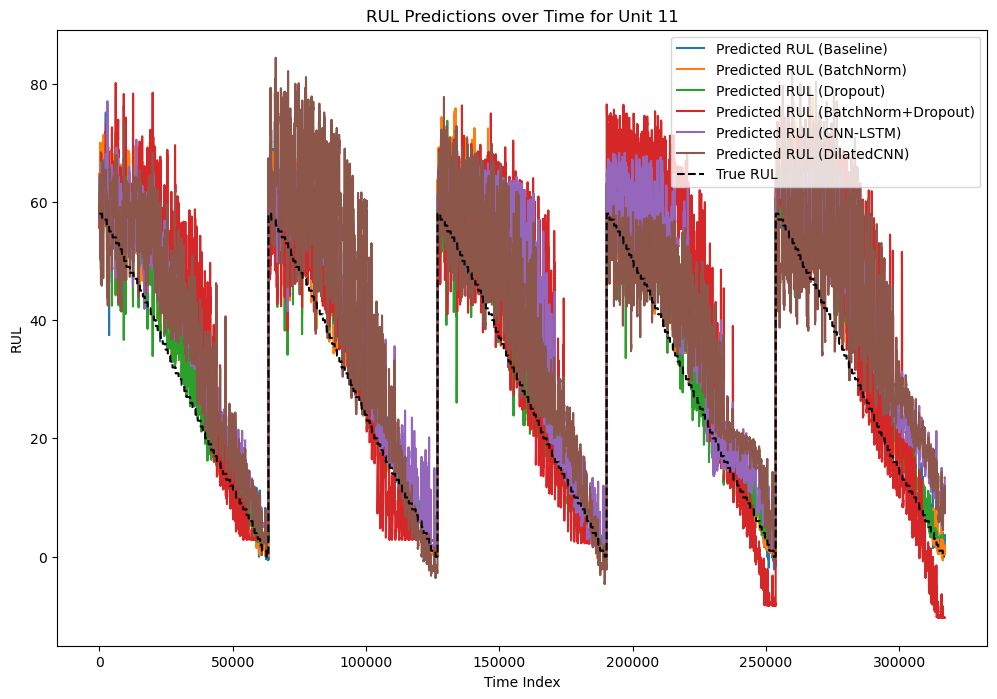

In [614]:
# Select a unit to analyze (e.g., unit 11)
unit_to_analyze = 11

plt.figure(figsize=(12, 8))

# Plot the predicted RULs from each configuration
for config in configurations:
    config_name = config['name']
    df_preds = results[config_name]['predictions']
    df_unit = df_preds[df_preds['unit'] == unit_to_analyze]
    df_unit = df_unit.sort_index()
    plt.plot(df_unit['pred'].values, label=f'Predicted RUL ({config_name})')

# Plot True RUL once
df_true_unit = results[configurations[0]['name']]['predictions']
df_true_unit = df_true_unit[df_true_unit['unit'] == unit_to_analyze]
df_true_unit = df_true_unit.sort_index()
plt.plot(df_true_unit['true'].values, label='True RUL', color='black', linestyle='dashed')

plt.xlabel('Time Index')
plt.ylabel('RUL')
plt.title(f'RUL Predictions over Time for Unit {unit_to_analyze}')
plt.legend()
plt.show()


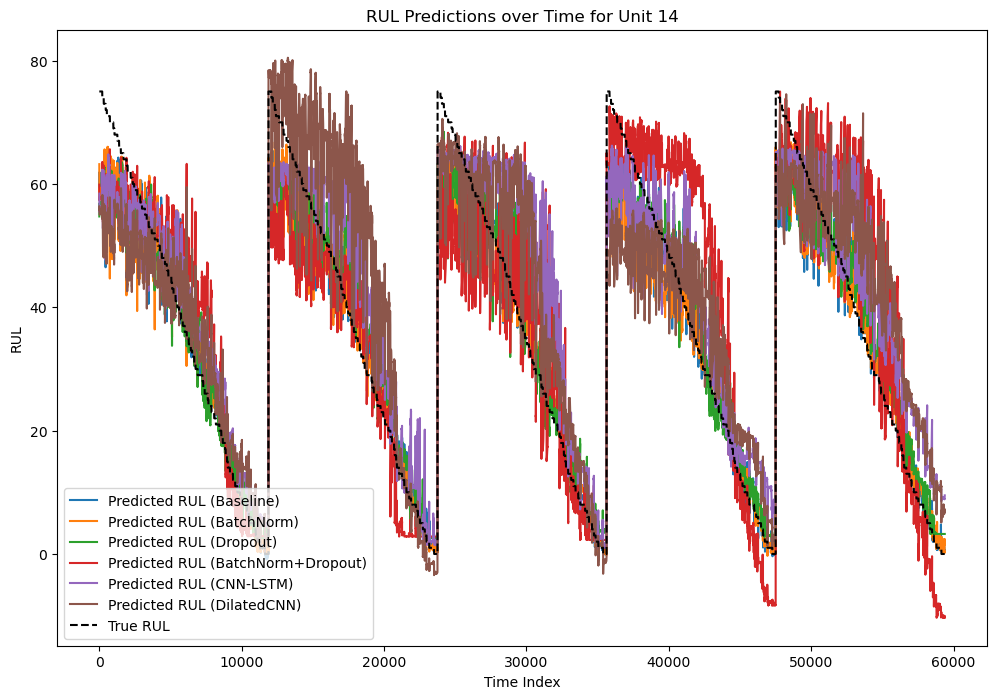

In [615]:
unit_to_analyze = 14

plt.figure(figsize=(12, 8))

# Plot the predicted RULs from each configuration
for config in configurations:
    config_name = config['name']
    df_preds = results[config_name]['predictions']
    df_unit = df_preds[df_preds['unit'] == unit_to_analyze]
    df_unit = df_unit.sort_index()
    plt.plot(df_unit['pred'].values, label=f'Predicted RUL ({config_name})')

# Plot True RUL once
df_true_unit = results[configurations[0]['name']]['predictions']
df_true_unit = df_true_unit[df_true_unit['unit'] == unit_to_analyze]
df_true_unit = df_true_unit.sort_index()
plt.plot(df_true_unit['true'].values, label='True RUL', color='black', linestyle='dashed')

plt.xlabel('Time Index')
plt.ylabel('RUL')
plt.title(f'RUL Predictions over Time for Unit {unit_to_analyze}')
plt.legend()
plt.show()


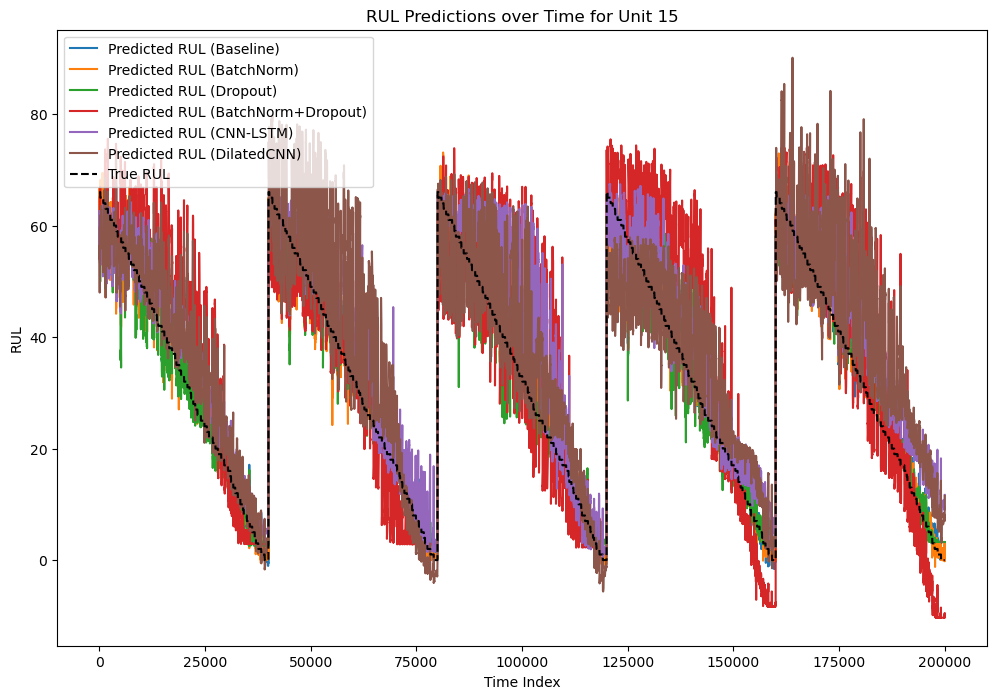

In [616]:
unit_to_analyze = 15

plt.figure(figsize=(12, 8))

# Plot the predicted RULs from each configuration
for config in configurations:
    config_name = config['name']
    df_preds = results[config_name]['predictions']
    df_unit = df_preds[df_preds['unit'] == unit_to_analyze]
    df_unit = df_unit.sort_index()
    plt.plot(df_unit['pred'].values, label=f'Predicted RUL ({config_name})')

# Plot True RUL once
df_true_unit = results[configurations[0]['name']]['predictions']
df_true_unit = df_true_unit[df_true_unit['unit'] == unit_to_analyze]
df_true_unit = df_true_unit.sort_index()
plt.plot(df_true_unit['true'].values, label='True RUL', color='black', linestyle='dashed')

plt.xlabel('Time Index')
plt.ylabel('RUL')
plt.title(f'RUL Predictions over Time for Unit {unit_to_analyze}')
plt.legend()
plt.show()


In [617]:
for config in configurations:
    config_name = config['name']
    print(f"\nPer-Unit Performance for {config_name}:")
    df_preds = results[config_name]['predictions']
    units = df_preds['unit'].unique()
    per_unit_metrics = []
    for unit in units:
        df_unit = df_preds[df_preds['unit'] == unit]
        score, rmse = Trainer.evaluate_model_performance(df_unit['pred'].values, df_unit['true'].values)
        per_unit_metrics.append({'unit': unit, 'rmse': rmse, 'score': score})
        print(f"Unit {unit}: RMSE = {rmse:.4f}, NASA Score = {score:.4f}")

    # Convert to DataFrame
    df_per_unit = pd.DataFrame(per_unit_metrics)
    results[config_name]['per_unit_metrics'] = df_per_unit



Per-Unit Performance for Baseline:
Unit 11: RMSE = 8.1158, NASA Score = 6.9402
Unit 14: RMSE = 6.0551, NASA Score = 0.9364
Unit 15: RMSE = 3.8299, NASA Score = 2.7082

Per-Unit Performance for BatchNorm:
Unit 11: RMSE = 8.8684, NASA Score = 7.6007
Unit 14: RMSE = 6.0314, NASA Score = 0.9129
Unit 15: RMSE = 3.8264, NASA Score = 2.6811

Per-Unit Performance for Dropout:
Unit 11: RMSE = 8.2116, NASA Score = 6.9439
Unit 14: RMSE = 6.6056, NASA Score = 0.9984
Unit 15: RMSE = 4.4586, NASA Score = 2.8492

Per-Unit Performance for BatchNorm+Dropout:
Unit 11: RMSE = 13.3038, NASA Score = 13.4407
Unit 14: RMSE = 11.3047, NASA Score = 1.8006
Unit 15: RMSE = 10.7967, NASA Score = 6.0327

Per-Unit Performance for CNN-LSTM:
Unit 11: RMSE = 11.3468, NASA Score = 10.1943
Unit 14: RMSE = 9.9457, NASA Score = 1.5751
Unit 15: RMSE = 8.2290, NASA Score = 4.4664

Per-Unit Performance for DilatedCNN:
Unit 11: RMSE = 11.3334, NASA Score = 10.5844
Unit 14: RMSE = 12.1448, NASA Score = 1.9942
Unit 15: RMSE = 

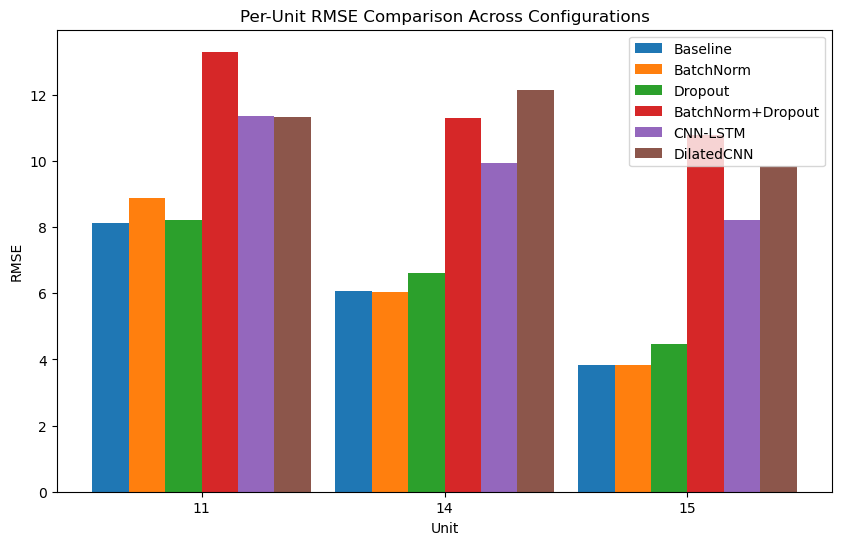

In [629]:
plt.figure(figsize=(10, 6))
bar_width = 0.15
index = np.arange(len(units))
for i, config in enumerate(configurations):
    config_name = config['name']
    df_per_unit = results[config_name]['per_unit_metrics']
    plt.bar(index + i * bar_width, df_per_unit['rmse'], bar_width, label=config_name)

plt.xlabel('Unit')
plt.ylabel('RMSE')
plt.title('Per-Unit RMSE Comparison Across Configurations')
plt.xticks(index + bar_width * (len(configurations) - 1) / 2, units)
plt.legend()
plt.show()


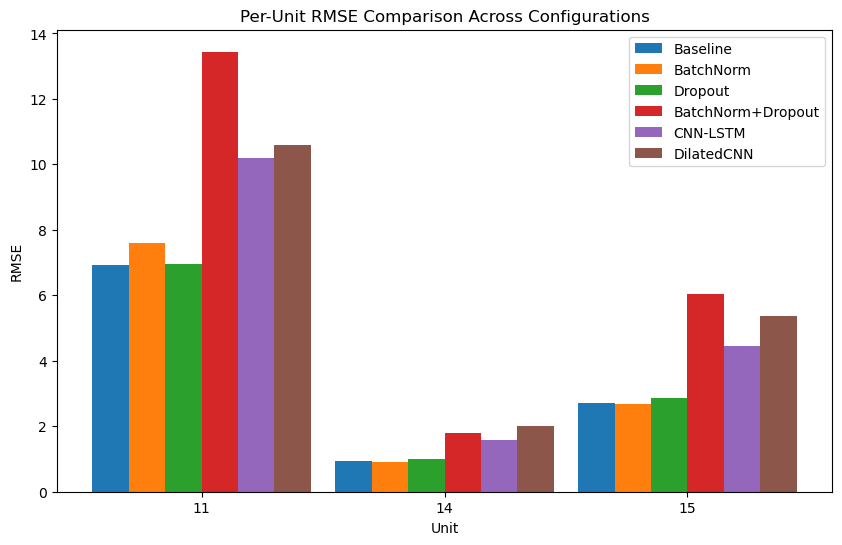

In [630]:
plt.figure(figsize=(10, 6))
bar_width = 0.15
index = np.arange(len(units))
for i, config in enumerate(configurations):
    config_name = config['name']
    df_per_unit = results[config_name]['per_unit_metrics']
    plt.bar(index + i * bar_width, df_per_unit['score'], bar_width, label=config_name)

plt.xlabel('Unit')
plt.ylabel('RMSE')
plt.title('Per-Unit RMSE Comparison Across Configurations')
plt.xticks(index + bar_width * (len(configurations) - 1) / 2, units)
plt.legend()
plt.show()


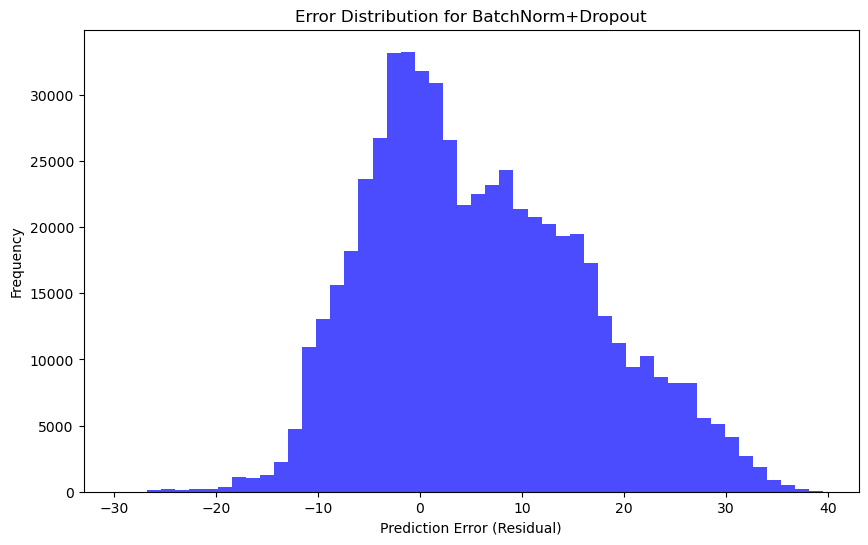

In [620]:
# Plot error distribution for a specific configuration
config_name = 'BatchNorm+Dropout'  # Change as needed
df_preds = results[config_name]['predictions']
errors = df_preds['pred'] - df_preds['true']

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for {config_name}')
plt.show()

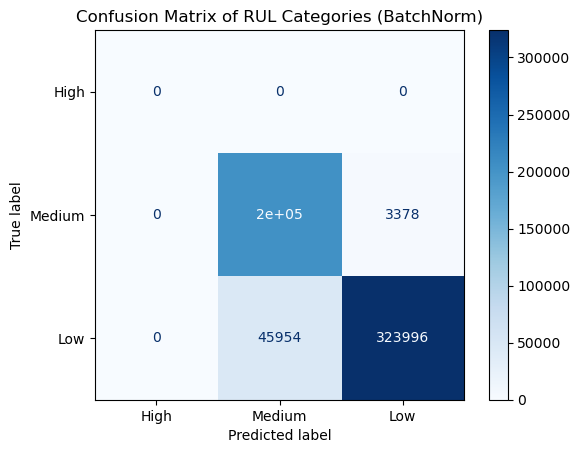

In [621]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def categorize_rul(rul):
    if rul > 80:
        return 'High'
    elif rul > 40:
        return 'Medium'
    else:
        return 'Low'

config_name = 'BatchNorm'  # Change as needed
df_preds = results[config_name]['predictions'].copy()
df_preds['true_category'] = df_preds['true'].apply(categorize_rul)
df_preds['pred_category'] = df_preds['pred'].apply(categorize_rul)

# Compute confusion matrix
cm = confusion_matrix(df_preds['true_category'], df_preds['pred_category'], labels=['High', 'Medium', 'Low'])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Medium', 'Low'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix of RUL Categories ({config_name})')
plt.show()

# Assignment 3: Prognostics for Turbofine Engines with 1D Convolutional Neural Networks 🩺

## I. Task Description:

### Background:
Conventional CNNs, primarily developed for image analysis, have shown immense capability in autonomously extracting features from 2D data. This autonomy, achieved through striding or windowing, enables the application of CNNs across various image dimensions without requiring domain expertise. 

Similarly, 1D CNNs have demonstrated effectiveness in time series data analysis by employing a windowing technique to scan through sequential data, extracting valuable features autonomously. This characteristic of 1D CNNs makes them a powerful tool for prognostics, a field concerned with predicting the Remaining Useful Life (RUL) of systems based on historical and real-time operational data.

### Problem Formulation 🚀:
In this task, the objective is to delve into the domain of prognostics to address a real-world problem. Utilizing the architecture described in the paper: "Fusing Physics-based and Deep Learning Models for Prognostics" ([link](https://arxiv.org/abs/2003.00732)), you have to develop a 1D CNN model to predict the Remaining Useful Life (RUL) of certain units. The provided dataset comprises time series data from different units, and your goal is to accurately estimate the RUL for specified test units.

Training units (engines) **2, 5, 10, 16, 18, 20** 

Test units (engines) **11, 14, 15** 

### Exploratory Data Analysis:
1. Explore and understand the provided dataset, identifying the key features that could be indicative of a unit's health and consequently its RUL **(10 points max)**.


### Implementation:
1. Implement the 1D CNN model as per the referenced paper **(20 points max)**. Be careful with the tensor dimensions that you pass to 1DCNN. It should have (n samples, n channels, n timesteps) dimensions.
2. Investigate the effect of Dropout and Batch Normalization layers on the model's performance as regularization techniques to mitigate overfitting **(10 points max)**.

### Interpretation:
1. How do the predictions of RUL evolve over time, within a cycle (i.e a complete flight cycle consisting of taking off, crusing and landing) and between cycles, for a given unit? Visualize and discuss **(30 points max)**.
2. How well does your model generalizes to the test units? Identify possible reasons why the model may perform better on some units and worse on others **(20 points max)**. 

### Evaluation:
The performance of your implemented model should be rigorously evaluated across 5 independent runs with different random seeds to ensure the robustness of the results. 
For each run, utilize the following two common metrics applied in C-MAPSS prognostics analysis:

The performance of your implemented model should be evaluated using two common metrics applied in C-MAPSS prognostics analysis:
1. **Root Mean Square Error (RMSE)**:

$\text{RMSE} = \sqrt{\frac{1}{m^*} \sum_{j=1}^{m^*} (\Delta(j))^2}$

where $m^*$ denotes the total number of test data samples, and $\Delta(j)$ is the difference between the estimated and the real Remaining Useful Life (RUL) of the $j$-th sample, i.e., $y(j) - \hat{y}(j)$.

2. **NASA's Scoring Function (s)**:
$s = \sum_{j=1}^{m^*} \exp\left(\alpha \cdot |\Delta(j)|\right) $
where $\alpha = \frac{1}{13}$ if RUL is underestimated, and $\alpha = \frac{1}{10}$ otherwise. The scoring function $s$ is not symmetric and penalizes over-estimation more than under-estimation.


Aggregate the results from all **5 runs** to provide a mean and standard deviation for both the RMSE and NASA's Scoring Function. This aggregated evaluation will provide a more robust understanding of the model's performance on the selected prognostics task, comparing it to purely data-driven deep learning models as outlined in the referenced paper.

We provide in total **(10 points max)** for proper evaluation of the model. 

## II. Report Submission:

Upon completion of the implementation and evaluation tasks, you are required to submit a comprehensive report summarizing your work and findings. Your report should span 5-8 pages and should be structured as follows:

#### Introduction:
- A brief introduction/literature review of 1D Convolutional Neural Networks (1DCNN) and their application in time series data analysis, particularly in prognostics.

#### Model Description:
- A detailed description of the 1DCNN model you implemented, including the architecture, layers, and any regularization techniques used.
- Mention of the hyperparameters that were tuned, and any additional modifications made to the original model architecture from the paper.

#### Methodology:
- Description of the data preparation process, training, and evaluation methodologies.
- Mention the training and testing units used as specified in the task.

#### Results and Discussion:
- Summarization of the evaluation results across 5 runs, providing the mean and standard deviation for both RMSE and NASA's Scoring Function.
- Evaluation of the performance per unit, and comparison of your model's performance with the results reported in the referenced paper.
- Discussion on the impact of Dropout and Batch Normalization (if applied), and any other observations regarding the model's performance.
- Any challenges faced during the implementation and how they were addressed.

#### Conclusion:
- Summary of key findings, lessons learned, and suggestions for future work to possibly improve the model's performance.

#### References:
- Proper citation of the paper, any other related works, and resources utilized in completing the assignment.

Ensure your report is well-organized, clear, and concise. Visual aids like graphs, tables, and diagrams should be used to enhance the explanation of your work, and comparisons made. The discussion should provide insightful analysis on the model's performance and a critical comparison with the paper's results. The report should be submitted in PDF format by **6.11.2024 Midnight 23:59**.
